# Retail Store Project

# Retail Restock Optimization using Reinforcement Learning

## Project Overview
This notebook implements a reinforcement learning solution for optimizing retail inventory restocking decisions. The project aims to develop an intelligent system that can learn optimal restocking policies while considering various factors such as demand patterns, storage costs, and stockout penalties.

## Objectives
- Develop a reinforcement learning model for inventory management
- Optimize restocking decisions to minimize costs and maximize efficiency
- Balance between holding costs and stockout risks
- Evaluate the model's performance in different scenarios

## Environment Setup
The project utilizes the following key libraries:
- Python 3.x
- NumPy for numerical computations
- Pandas for data manipulation
- Gym for reinforcement learning environment
- TensorFlow/PyTorch for deep learning implementation

## Project Structure
1. Environment Definition
2. Agent Implementation
3. Training Process
4. Performance Evaluation
5. Results Analysis

## Expected Outcomes
- A trained RL agent capable of making intelligent restocking decisions
- Comparative analysis with traditional inventory management methods
- Insights into optimal inventory policies
- Performance metrics and visualizations

---
*Note: This project demonstrates the application of reinforcement learning in real-world retail operations management.*


## Packages

In [4]:
%matplotlib inline
import math
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt
from environments.rl_glue import RLGlue
from agents import agent
from agents import main_agent
from environments import store_env
from tqdm import tqdm
import pickle
from collections import defaultdict
from mpl_toolkits.mplot3d import axes3d
import gym
import sys
from utils.plot_utils import plot_values, plot_policy
from utils import plot_utils
from importlib import reload
import os
import shutil
import matplotlib
from itertools import count
from collections import Counter
from collections import namedtuple, deque
import random
import seaborn as sns

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from torch.distributions import Categorical

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device ='cpu'

In [6]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'figure.figsize': [16,5]})

## Functions

In [7]:
def plot_results_rw(all_reward_sums,all_waste_sums, algos, args={}):
    fig, ax  = plt.subplots(2, 1, figsize=(12, 6*len(algos)), sharex='all')
    ax = ax.flatten()
    x_lim = args.get('x_lim', None)
    title = args.get('title', 'Agent performance')
    for algorithm in algos:
        x_l = range(len(all_reward_sums[algorithm][0]))
        mean_val = np.mean(all_reward_sums[algorithm], axis=0)
        std_val = sem(all_reward_sums[algorithm], axis=0)
        ax[0].plot(x_l, mean_val, label=algorithm)
        ax[0].fill_between(x_l,mean_val - std_val, mean_val + std_val, alpha=0.3)
        ax[0].set_ylabel("Rewards")
        ax[0].set_xlim(x_lim)
        ax[1].set_xlabel('Episodes')
        # ax2 = plt.twinx()
        waste_avg = np.mean(all_waste_sums[algorithm], axis=0)
        std_waste = sem(waste_avg, axis=0)
        ax[1].plot(waste_avg, label=algorithm)
        ax[1].fill_between(x_l,waste_avg - std_waste, waste_avg + std_waste, alpha=0.3)
        ax[1].set_ylabel('Sum of waste')
    
    plt.legend()
    ax[0].set_title(title)
    plt.show()

In [8]:
def argmax(q_values):
    """
    Takes in a list of q_values and returns the index
    of the item with the highest value. Breaks ties randomly.
    returns: int - the index of the highest value in q_values
    """
    top = float("-inf")
    ties = []
    
    for i in range(len(q_values)):
        # if a value in q_values is greater than the highest value, then update top and reset ties to zero
        # if a value is equal to top value, then add the index to ties (hint: do this no matter what)
        # Note: You do not have to follow this exact solution. You can choose to do your own implementation.
        ### START CODE HERE ###
        if(q_values[i]>top):
            top = q_values[i]
            ties = []
            ties.append(i)
        elif(q_values[i] == top):
            ties.append(i)
        ### END CODE HERE ###
    ind = np.random.choice(ties, 1)
    # print(ind[0])
    # return a random selection from ties. (hint: look at np.random.choice)
        
    return ind[0]

# Agents

This section implements the reinforcement learning agents responsible for making inventory restocking decisions. Each agent type employs different strategies and learning mechanisms to optimize the restocking policy.


### Greedy

In [9]:
class GreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent received from the environment after taking the last action.
        observation -- float, the observed state the agent is in.
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        ### Useful Class Variables ###
        # self.q_values : An array with the agent’s value estimates for each action.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : The action that the agent took on the previous time step.
        #######################
        

        # (~3-5 lines)
        self.arm_count[self.last_action] += 1
        self.q_values[self.last_action] += (reward-self.q_values[self.last_action])/self.arm_count[self.last_action]
        
        # current action = ? # Use the argmax function you created above
        # (~2 lines)
        current_action = self.argmax(self.q_values)

        # print(current_action)
        self.last_action = current_action
        
        return current_action
    def argmax(self, q_values):
        """
        Takes in a list of q_values and returns the index
        of the item with the highest value. Breaks ties randomly.
        returns: int - the index of the highest value in q_values
        """
        top = float("-inf")
        ties = []
        
        for i in range(len(q_values)):
            # if a value in q_values is greater than the highest value, then update top and reset ties to zero
            # if a value is equal to top value, then add the index to ties (hint: do this no matter what)
            # Note: You do not have to follow this exact solution. You can choose to do your own implementation.
            ### START CODE HERE ###
            if(q_values[i]>top):
                top = q_values[i]
                ties = []
                ties.append(i)
            elif(q_values[i] == top):
                ties.append(i)
            ### END CODE HERE ###
        ind = np.random.choice(ties, 1)
        # print(ind[0])
        # return a random selection from ties. (hint: look at np.random.choice)

        
        return ind[0]

### eps-Greedy

In [12]:
# Epsilon Greedy Agent here [Graded]
class EpsilonGreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent received from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this for this assignment 
        as you will not use it until future lessons.
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        
        ### Useful Class Variables ###
        # self.q_values : An array with the agent’s value estimates for each action.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : The action that the agent took on the previous time step.
        # self.epsilon : The probability an epsilon greedy agent will explore (ranges between 0 and 1)
        #######################
        
        # Update action-values - this should be the same update as your greedy agent above
        # (~2-5 lines)
        self.arm_count[self.last_action] += 1
        self.q_values[self.last_action] += (reward - self.q_values[self.last_action])/self.arm_count[self.last_action]

        
        # Choose action using epsilon greedy
        # Randomly choose a number between 0 and 1 and see if it is less than self.epsilon
        # (Hint: look at np.random.random()). If it is, set current_action to a random action.
        # Otherwise choose current_action greedily as you did above.
        # (~4 lines)

        val = np.random.random()
        if val<self.epsilon:
            # Randomly select an actin to explore results
            current_action = np.random.randint(0,self.num_actions)
        else:
            current_action = argmax(self.q_values)
        
        self.last_action = current_action
        
        return current_action

## Fixed Policy Agent

In [13]:
# [Graded]
# Q-Learning agent here
class FixedAgent(agent.BaseAgent):
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.expiration = agent_init_info["expiration"]
        self.rand_generator = np.random.RandomState(agent_init_info.get("seed", 0))
        
        # Create an array for action-value estimates and initialize it to zero.
        # self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.
        self.q = defaultdict(lambda: np.zeros(self.num_actions)) # The array of action-value estimates.
    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        
        # Choose action using fixed policy
        qty_left, expiration = state
        if(qty_left < self.num_actions//2 or expiration < self.expiration//2):
            action = self.num_actions//2
        else:
            action = 0
        
        
        return action
    
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        qty_left, expiration = state
        if(qty_left < self.num_actions//2 or expiration < self.expiration//2):
            action = self.num_actions//2
        else:
            action = 0
        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        pass
    

## Q-Learning

In [14]:
# Q-Learning agent here
class QLearningAgent(agent.BaseAgent):
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        
        # Create an array for action-value estimates and initialize it to zero.
        # self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.
        self.q = defaultdict(lambda: np.zeros(self.num_actions)) # The array of action-value estimates.
    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        
        # Choose action using epsilon greedy.
        
        current_q = self.q[state]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # random action selection
        else:
            action = self.argmax(current_q) # greedy action selection
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        # print('start step')
        # Choose action using epsilon greedy.
        current_q = self.q[state]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        # Perform an update (1 line)
        self.q[self.prev_state][self.prev_action] += self.step_size*(reward + self.discount*np.max(current_q) -self.q[self.prev_state][self.prev_action])
        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode (1 line)
        self.q[self.prev_state][self.prev_action] += self.step_size*(reward- self.q[self.prev_state][self.prev_action])
        
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []
        
        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

## Expected Sarsa

In [15]:
# Expected Sarsa agent here
class ExpectedSarsaAgent(agent.BaseAgent):
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        
        # Create an array for action-value estimates and initialize it to zero.
        # self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.
        self.q = defaultdict(lambda: np.zeros(self.num_actions)) # The array of action-value estimates.
        
    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[state]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[state]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        # Perform an update (~5 lines)
        ### START CODE HERE ###
        expectation = 0
        for act in range(self.num_actions):
            if(act == np.argmax(self.q[state])):
                expectation += self.q[state][act]*self.epsilon # Epsilon greedy
            expectation += self.q[state][act] / self.num_actions
        self.q[self.prev_state][self.prev_action] += self.step_size*(reward + self.discount*expectation -self.q[self.prev_state][self.prev_action])
        ### END CODE HERE ###
        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode (1 line)
        self.q[self.prev_state][self.prev_action] += self.step_size*(reward-self.q[self.prev_state][self.prev_action])
        
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

## Lambda Sarsa

In [16]:
class LambdaSarsaAgent(agent.BaseAgent):
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
            agent_init_info (dict): The parameters used to initialize the agent. The dictionary contains:
                {
                    num_states (int): The number of states,
                    num_actions (int): The number of actions,
                    epsilon (float): The epsilon parameter for exploration,
                    step_size (float): The step-size,
                    discount (float): The discount factor,
                    trace_decay (float): The trace decay parameter (lambda),
                }
        """
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.trace_decay = agent_init_info["trace_decay"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        
        self.q = defaultdict(lambda: np.zeros(self.num_actions))  # The action-value estimates.
        self.e = defaultdict(lambda: np.zeros(self.num_actions))  # Eligibility traces.

    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        
        Args:
            state (int): The state from the environment's env_start function.
        
        Returns:
            action (int): The first action the agent takes.
        """
        current_q = self.q[state]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        self.prev_state = state
        self.prev_action = action
        return action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        
        Args:
            reward (float): The reward received for taking the last action.
            state (int): The state from the environment's step based on where the agent ended up after the last step.
        
        Returns:
            action (int): The action the agent is taking.
        """
        current_q = self.q[state]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        delta = reward + self.discount * self.q[state][action] - self.q[self.prev_state][self.prev_action]
        self.e[self.prev_state][self.prev_action] += 1
        
        for s in self.q:
            for a in range(self.num_actions):
                self.q[s][a] += self.step_size * delta * self.e[s][a]
                self.e[s][a] *= self.discount * self.trace_decay
        
        self.prev_state = state
        self.prev_action = action
        return action

    def agent_end(self, reward):
        """Run when the agent terminates.
        
        Args:
            reward (float): The reward the agent received for entering the terminal state.
        """
        delta = reward - self.q[self.prev_state][self.prev_action]
        self.e[self.prev_state][self.prev_action] += 1
        
        for s in self.q:
            for a in range(self.num_actions):
                self.q[s][a] += self.step_size * delta * self.e[s][a]
                self.e[s][a] *= self.discount * self.trace_decay

    def argmax(self, q_values):
        """argmax with random tie-breaking.
        
        Args:
            q_values (numpy.array): The array of action-values.
        
        Returns:
            action (int): An action with the highest value.
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)


# Environment tests

## Basic

0 :  8.8  -> (14, 29)
1 :  4.9  -> (12, 28)
2 :  5.9  -> (9, 27)
3 :  2.9  -> (9, 27)
4 :  1.9  -> (10, 26)
5 :  2.9  -> (10, 26)
6 :  5.9  -> (7, 26)
7 :  4.9  -> (5, 27)
8 :  5.0  -> (3, 28)
9 :  4.0  -> (2, 28)
10 :  5.0  -> (0, 30)
11 :  3.0  -> (0, 30)
12 :  1.0  -> (0, 30)
13 :  3.0  -> (0, 30)
14 :  2.0  -> (0, 30)
15 :  3.0  -> (0, 30)
16 :  2.0  -> (1, 29)
17 :  4.0  -> (0, 30)
18 :  1.0  -> (0, 30)
19 :  -2.0  -> (0, 30)
20 :  0.0  -> (3, 29)
21 :  1.0  -> (5, 28)
22 :  4.0  -> (4, 28)
23 :  6.0  -> (0, 30)
24 :  0.0  -> (0, 30)
25 :  3.0  -> (0, 30)
26 :  -2.0  -> (0, 30)
27 :  -5.0  -> (0, 30)
28 :  1.0  -> (0, 30)
29 :  1.0  -> (0, 30)
30 :  0.0  -> (0, 30)
31 :  2.0  -> (0, 30)
32 :  3.0  -> (0, 30)
33 :  1.0  -> (0, 30)
34 :  0.0  -> (0, 30)
35 :  1.0  -> (0, 30)
36 :  -1.0  -> (0, 30)
37 :  -1.0  -> (0, 30)
38 :  0.0  -> (0, 30)
39 :  2.0  -> (1, 29)
40 :  -1.0  -> (0, 30)
41 :  3.0  -> (0, 30)
42 :  3.0  -> (0, 30)
43 :  -1.0  -> (0, 30)
44 :  0.0  -> (0, 30)
45 :  2.0

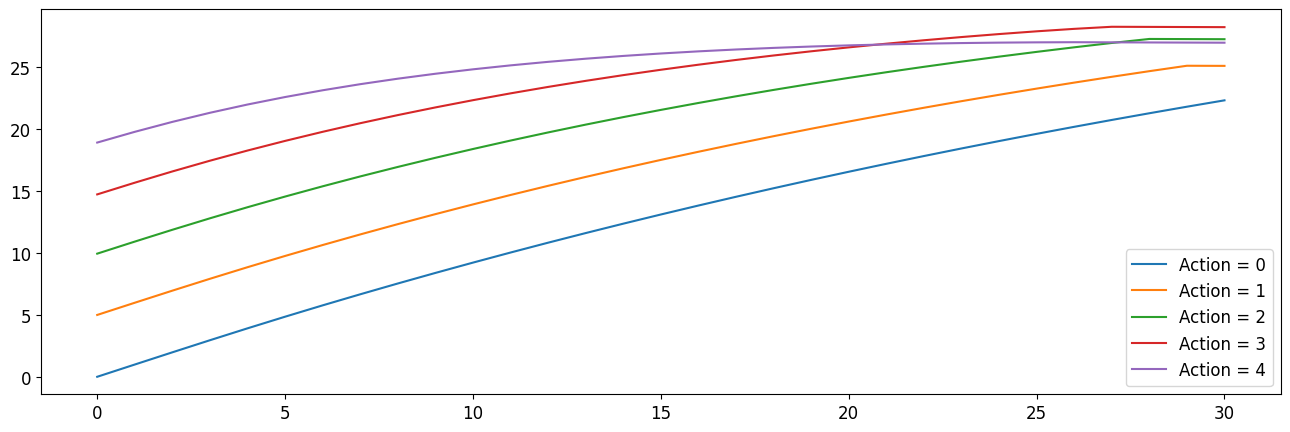

In [10]:
cap = 30
exp = 30 # 30 days expiration per product
env_info = {'capacity': cap,
            'maintenance_cost':0.01,
            'expiration_time': exp,
            'buying_price': 0.5,
            'selling_price': 1,
            'expiration_cost':1, 
            'weekly_demand':5,
            'gamma':0.925,
            'max_time':100}
agent_info = {"num_actions": cap + 1, "num_states": (cap + 1)*exp,"expiration":exp, "epsilon": 0.1, "step_size": 0.5, "discount": 1.0}
env = store_env.Environment()
env.env_init(env_info)
env.env_start()
gamma = 0.9
action = 3
n = 50
w = 1
v = 0
for _ in range(n):
    x = env.env_step(action)
    print(env.time-1, ': ', '{:.1f}'.format(x[0]), ' ->', env.current_state)
    v += w*x[0]
    w *= gamma
print('Discounted reward:', '{:.1f}'.format(v))

pi = np.zeros((env_info['capacity'] + 1, env_info['expiration_time'] + 1)) # Policy
pi[:, 0] = 1
plt.plot(env.value_policy(pi, gamma), label="Action = 0")
pi = np.zeros((env_info['capacity'] + 1, env_info['expiration_time'] + 1))  # Policy
pi[:, 1] = 1
plt.plot(env.value_policy(pi, gamma), label="Action = 1")
pi = np.zeros((env_info['capacity'] + 1, env_info['expiration_time'] + 1))  # Policy
pi[:, 2] = 1
plt.plot(env.value_policy(pi, gamma), label="Action = 2")
pi = np.zeros((env_info['capacity'] + 1, env_info['expiration_time'] + 1))  # Policy
pi[:, 3] = 1
plt.plot(env.value_policy(pi, gamma), label="Action = 3")
pi = np.zeros((env_info['capacity'] + 1, env_info['expiration_time'] + 1))  # Policy
pi[:, 4] = 1
plt.plot(env.value_policy(pi, gamma), label="Action = 4")

plt.legend()

## Greedy

100%|██████████| 200/200 [00:14<00:00, 13.59it/s]


<Figure size 1200x400 with 0 Axes>

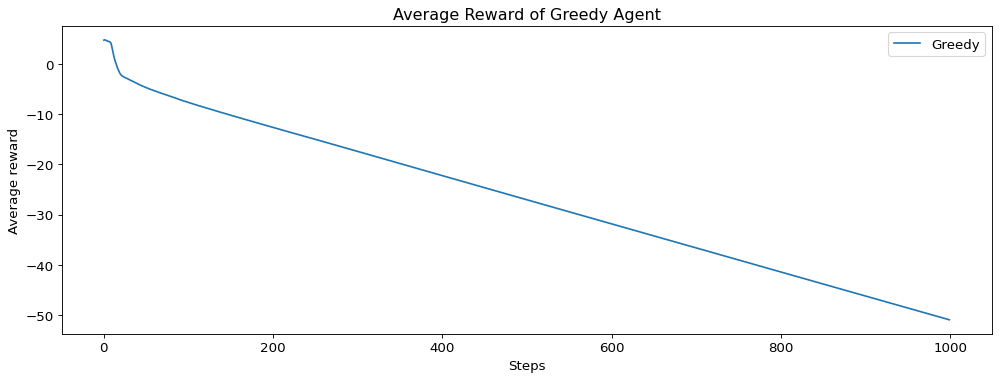

In [382]:
# Plot Greedy Result
num_runs = 200                    # The number of times we run the experiment
num_steps = 1000                  # The number of steps each experiment is run for
env = store_env.Environment     # The environment to use
agent_chosen = GreedyAgent               # We choose what agent we want to use
all_averages = []
for i in tqdm(range(num_runs)):           # tqdm is what creates the progress bar below once the code is run
    rl_glue = RLGlue(env, agent_chosen)          # Creates a new RLGlue experiment with the env and agent we chose above
    rl_glue.rl_init(agent_info, env_info) # Pass RLGlue what it needs to initialize the agent and environment
    rl_glue.rl_start()                    # Start the experiment

    scores = [0]
    averages = []
    
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Greedy"])
plt.title("Average Reward of Greedy Agent")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()
greedy_scores = np.mean(all_averages, axis=0)
np.save("greedy_scores", greedy_scores)

## EpsilonGreedy

100%|██████████| 200/200 [00:13<00:00, 15.18it/s]


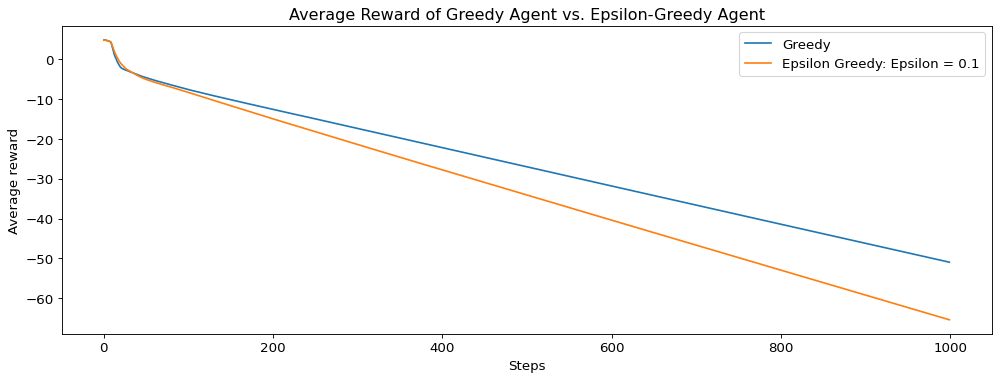

In [383]:
# Plot Greedy Result
num_runs = 200                    # The number of times we run the experiment
num_steps = 1000                  # The number of steps each experiment is run for
epsilon = 0.25
env = store_env.Environment     # The environment to use
agent_chosen = EpsilonGreedyAgent               # We choose what agent we want to use
all_averages = []
agent_info = {"num_actions": cap + 1, 
              "num_states": (cap + 1)*exp,
              "expiration":exp, 
              "epsilon": epsilon, 
              "step_size": 0.5, 
              "discount": 1.0}

for i in tqdm(range(num_runs)):           # tqdm is what creates the progress bar below once the code is run
    rl_glue = RLGlue(env, agent_chosen)          # Creates a new RLGlue experiment with the env and agent we chose above
    rl_glue.rl_init(agent_info, env_info) # Pass RLGlue what it needs to initialize the agent and environment
    rl_glue.rl_start()                    # Start the experiment

    scores = [0]
    averages = []
    
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(greedy_scores)
plt.title("Average Reward of Greedy Agent vs. Epsilon-Greedy Agent")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(("Greedy", "Epsilon Greedy: Epsilon = 0.1"))
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()
np.save("e-greedy", all_averages)

## Fixed Agent

In [17]:
agents = {
    "Fixed Agent": FixedAgent,
}
cap = 30
exp = 10 # days expiration per product
env_info = {'capacity': cap,
            'initial_stock': cap,
            'maintenance_cost':0.01,
            'expiration_time': exp,
            'buying_price': 0.5,
            'selling_price': 1,
            'expiration_cost':1, 
            'weekly_demand':5,
            'gamma':0.925,
            'max_time':365,
            'max_loss': 200
            }
agent_info = {"num_actions": cap + 1, 
              "num_states": (cap + 1)*(exp+1),
              "expiration": exp, 
              "epsilon": 0.1, 
              "step_size": 0.8, 
              "discount": 1.0}

env = store_env.Environment
all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
all_policies ={}
all_waste_sums = {}
num_runs = 10 # The number of runs
num_episodes = 100 # The number of episodes in each run
# algos =["Q-learning"]
algos =["Fixed Agent"]
for algorithm in algos:
    all_reward_sums[algorithm] = []
    all_state_visits[algorithm] = []
    all_policies[algorithm] = []
    all_waste_sums[algorithm] = []
    for run in tqdm(range(num_runs)):
        agent_info["seed"] = run
        rl_glue = RLGlue(env, agents[algorithm])
        rl_glue.rl_init(agent_info, env_info)
        reward_sums = []
        waste_sums = []
        state_visits = defaultdict(lambda: np.zeros(rl_glue.agent.num_actions))
#         last_episode_total_reward = 0
        for episode in range(num_episodes):
            if episode < num_episodes - 10:
                # Runs an episode
                rl_glue.rl_episode(0) 
            else: 
                # Runs an episode while keeping track of visited states
                state, action = rl_glue.rl_start()
                state_visits[state] += 1
                is_terminal = False
                while not is_terminal:
                    reward, state, action, is_terminal = rl_glue.rl_step()
                    state_visits[state] += 1
                
            reward_sums.append(rl_glue.rl_return())
            waste_sums.append(rl_glue.environment.total_waste)
#             last_episode_total_reward = rl_glue.rl_return()
        policy = dict((k,np.argmax(v)) for k, v in rl_glue.agent.q.items())
        all_policies[algorithm].append(policy)    
        all_reward_sums[algorithm].append(reward_sums)
        all_waste_sums[algorithm].append(waste_sums)
        all_state_visits[algorithm].append(state_visits)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


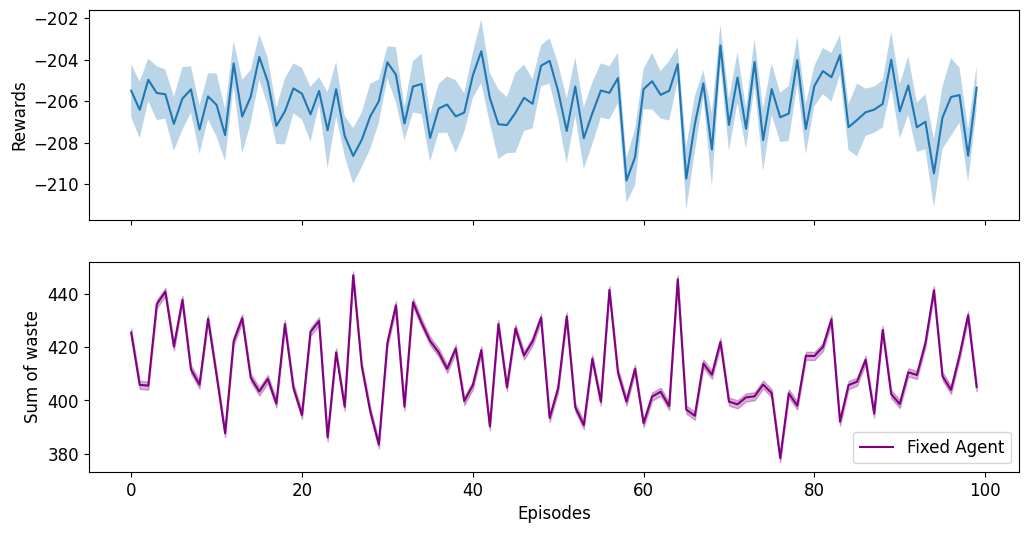

In [43]:
fig, ax  = plt.subplots(len(algos)*2, 1, figsize=(12, 6*len(algos)), sharex='all')
ax = ax.flatten()
for algorithm in algos:
    x_l = range(num_episodes)
    mean_val = np.mean(all_reward_sums[algorithm], axis=0)
    std_val = sem(all_reward_sums[algorithm])
    ax[0].plot(x_l, mean_val, label=algorithm)
    ax[0].fill_between(x_l,mean_val - std_val, mean_val + std_val, alpha=0.3)
    ax[0].set_ylabel("Rewards")
    plt.xlabel("Episodes")
    # ax2 = plt.twinx()
    waste_avg = np.mean(all_waste_sums[algorithm], axis=0)
    std_waste = sem(waste_avg)
    ax[1].plot(waste_avg,color='purple', label=algorithm)
    ax[1].fill_between(x_l,waste_avg - std_waste, waste_avg + std_waste, alpha=0.3, color='purple')
    ax[1].set_ylabel('Sum of waste')
plt.legend()
plt.show()

## QLearning - Sarsa

In [44]:
algos =["Q-learning", "Expected Sarsa"]

In [56]:
agents = {
    "Q-learning": QLearningAgent,
    "Expected Sarsa": ExpectedSarsaAgent
}
cap = 30
exp = 10 # days expiration per product
env_info = {'capacity': 30,
            'initial_stock': 30,
            'maintenance_cost':0.01,
            'expiration_time': 10,
            'buying_price': 0.5,
            'selling_price': 1,
            'expiration_cost':1, 
            'weekly_demand':5,
            'gamma':0.925,
            'max_time':365,
            'max_loss': 200
            }
agent_info = {"num_actions": cap + 1, 
              "num_states": (cap + 1)*(exp+1),
              "expiration": exp, 
              "epsilon": 0.1, 
              "step_size": 0.8, 
              "discount": 1.0}
env = store_env.Environment
all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
all_policies ={}
all_waste={}
num_runs = 10 # The number of runs
num_episodes = 1000 # The number of episodes in each run
# algos =["Q-learning"]

for algorithm in algos:
    all_reward_sums[algorithm] = []
    all_state_visits[algorithm] = []
    all_policies[algorithm] = []
    all_waste[algorithm] = []
    for run in tqdm(range(num_runs)):
        agent_info["seed"] = run
        rl_glue = RLGlue(env, agents[algorithm])
        rl_glue.rl_init(agent_info, env_info)
        reward_sums = []
        wastes = []
        state_visits = defaultdict(lambda: np.zeros(rl_glue.agent.num_actions))
#         last_episode_total_reward = 0
        for episode in range(num_episodes):
            if episode < num_episodes - 10:
                # Runs an episode
                rl_glue.rl_episode(0) 
            else: 
                # Runs an episode while keeping track of visited states
                state, action = rl_glue.rl_start()
                state_visits[state] += 1
                is_terminal = False
                while not is_terminal:
                    reward, state, action, is_terminal = rl_glue.rl_step()
                    state_visits[state] += 1
            wastes.append(rl_glue.environment.total_waste)   
            reward_sums.append(rl_glue.rl_return())
#             last_episode_total_reward = rl_glue.rl_return()
        policy = dict((k,np.argmax(v)) for k, v in rl_glue.agent.q.items())
        all_waste[algorithm].append(wastes)
        all_policies[algorithm].append(policy)    
        all_reward_sums[algorithm].append(reward_sums)
        all_state_visits[algorithm].append(state_visits)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [02:12<00:00, 13.28s/it]


In [58]:
# save results
for algo in algos:
    np.save(f'results/{algo}_learning.npy', all_reward_sums[algo])
    np.save(f'results/{algo}_waste.npy', all_waste[algo])

In [45]:
for algo in algos:
    all_reward_sums[algo] = np.load(f'results/{algo}_learning.npy')

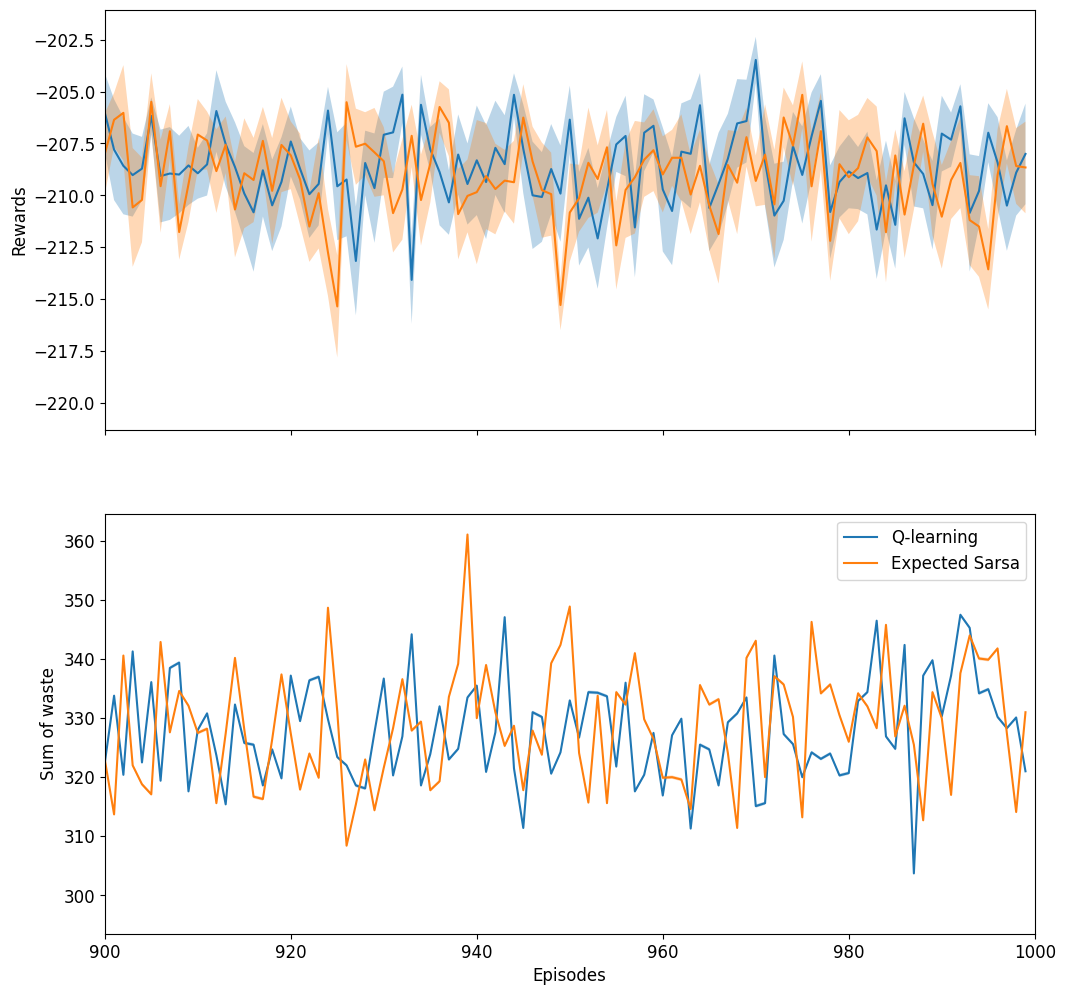

In [65]:
plot_results_rw(all_reward_sums, all_waste, algos, {'x_lim':(900, 1000)})

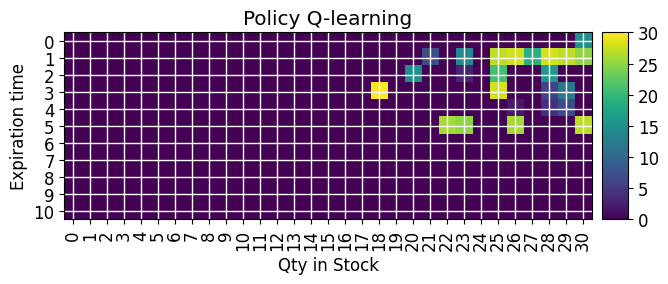

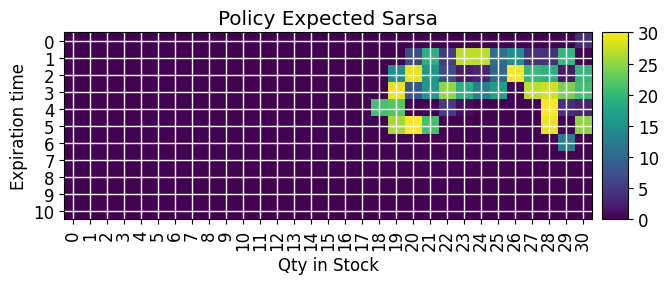

In [66]:
for algo in algos:
    plot_utils.plot_policy(all_policies[algo][-1],exp + 1, cap + 1, 0, {'title':f'Policy {algo}'})

### Env setup without Exp cost

In [284]:
agents = {
    "Q-learning": QLearningAgent,
    "Expected Sarsa": ExpectedSarsaAgent
}
cap = 30
exp = 10 # days expiration per product
env_info = {'capacity': cap,
            'initial_stock': cap,
            'maintenance_cost':0,
            'expiration_time': exp,
            'buying_price': 0.5,
            'selling_price': 1,
            'expiration_cost':0, 
            'weekly_demand':5,
            'gamma':0.925,
            'max_time':100,
            'max_loss': 100
            }
agent_info = {"num_actions": cap + 1, 
              "num_states": (cap + 1)*(exp +1),
              "epsilon": 0.1, 
              "step_size": 0.5, 
              "discount": 1.0}

env = store_env.Environment
all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
all_policies = {}
num_runs = 30 # The number of runs
num_episodes = 100 # The number of episodes in each run
# algos =["Q-learning"]
algos =["Q-learning", "Expected Sarsa"]
# algos =["Expected Sarsa"]
for algorithm in algos:
    all_reward_sums[algorithm] = []
    all_state_visits[algorithm] = []
    all_policies[algorithm] = []
    for run in tqdm(range(num_runs)):
        agent_info["seed"] = run
        rl_glue = RLGlue(env, agents[algorithm])
        rl_glue.rl_init(agent_info, env_info)
        reward_sums = []
        state_visits = defaultdict(lambda: np.zeros(rl_glue.agent.num_actions))
#         last_episode_total_reward = 0
        for episode in range(num_episodes):
            if episode < num_episodes - 10:
                # Runs an episode
                rl_glue.rl_episode(0) 
            else: 
                # Runs an episode while keeping track of visited states
                state, action = rl_glue.rl_start()
                state_visits[state] += 1
                is_terminal = False
                while not is_terminal:
                    reward, state, action, is_terminal = rl_glue.rl_step()
                    state_visits[state] += 1
                
            reward_sums.append(rl_glue.rl_return())
#             last_episode_total_reward = rl_glue.rl_return()
        policy = dict((k,np.argmax(v)) for k, v in rl_glue.agent.q.items())
        all_policies[algorithm].append(policy)
        all_reward_sums[algorithm].append(reward_sums)
        all_state_visits[algorithm].append(state_visits)

100%|██████████| 30/30 [00:44<00:00,  1.50s/it]


In [208]:

def get_policy(data):
    combined_data = {}
    for d in data:
        combined_data.update(d)

    # Create a Counter object to count the occurrences of each value for each key
    counter = Counter({key: [val] for d in data for key, val in d.items()})

    # Find the most common value for each key
    most_common_per_key = {key: value[0] for key, value in counter.most_common()}
    return most_common_per_key

In [266]:
p_sarsa = get_policy(all_policies["Expected Sarsa"])

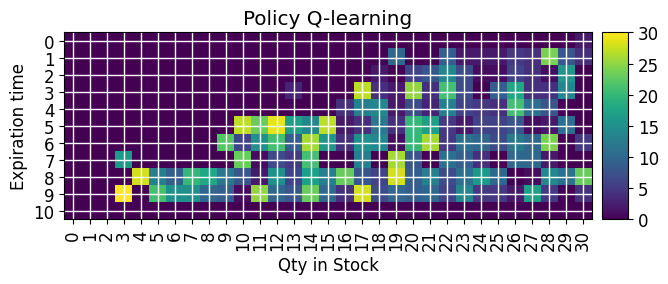

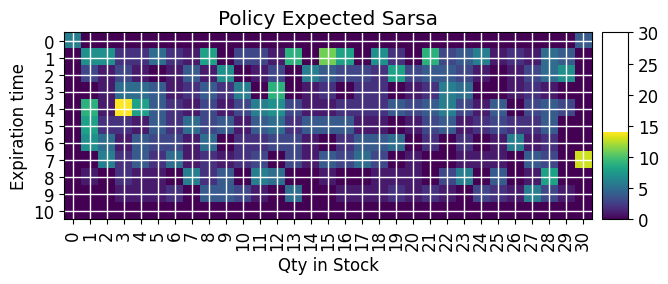

In [285]:
for algo in algos:
    plot_utils.plot_policy(all_policies[algo][-1],exp + 1, cap + 1, 0, {'title':f'Policy {algo}'})

In [286]:
# save results
os.makedirs('results', exist_ok=True)
for algo in algos:
    np.save(f'results/{algo}_case_nowaste_learning.npy', all_reward_sums[algo])
shutil.make_archive('results', 'zip', '.', 'results')

'e:\\My Drive\\Dsba\\05 M2 T2\\Reinforcement Learning\\Project\\results.zip'

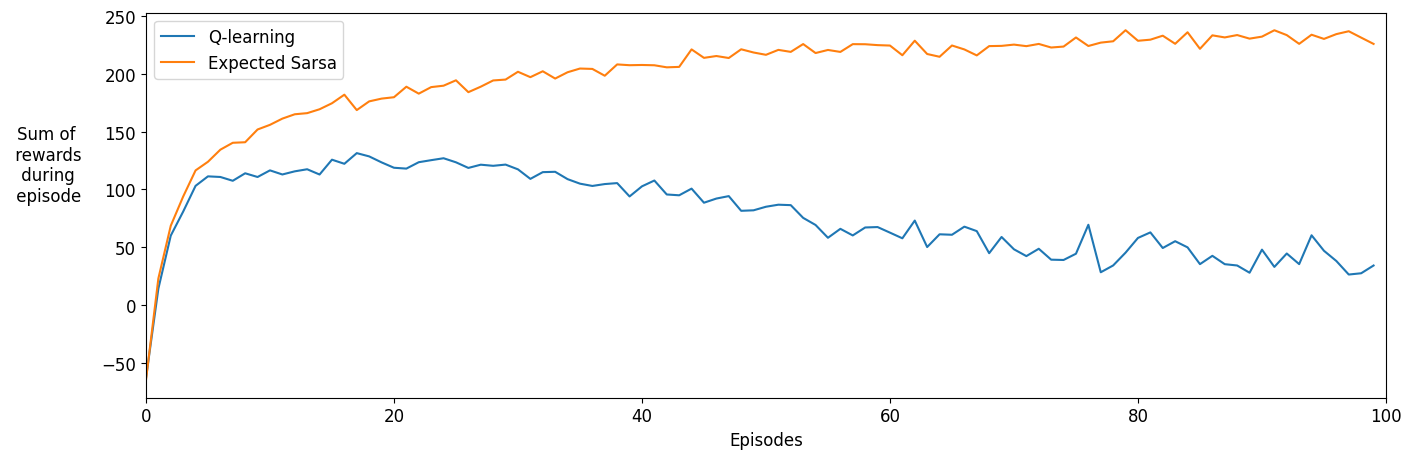

In [287]:
for algorithm in algos:
    plt.plot(np.mean(all_reward_sums[algorithm], axis=0), label=algorithm)
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.xlim(0, num_episodes)
plt.legend()
plt.show()

When assuming no cost of waste or maintenance cost, the Expected Sarsa agent manage to learn to get around 230 in reward. However, the Q-learning agent learns a decision function to keep zero reward mostly.

## Lambda Sarsa

In [ ]:
env_info = {'capacity': cap,
            'initial_stock': cap,
            'maintenance_cost':0.01,
            'expiration_time': exp,
            'buying_price': 0.5,
            'selling_price': 1,
            'expiration_cost':1, 
            'weekly_demand':5,
            'gamma':0.925,
            'max_time':365,
            'max_loss': 1000
            }
agent_info = {"num_actions": cap + 1, 
              "num_states": (cap + 1)*(exp+1),
              "expiration": exp, 
              "epsilon": 0.1, 
              "step_size": 0.8, 
              "discount": 1.0}
agents = {
    "Q-learning": QLearningAgent,
    "Expected Sarsa": ExpectedSarsaAgent,
    "Lambda Sarsa": LambdaSarsaAgent
}
env = store_env.Environment
all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
all_policies = {}
all_waste={}

num_runs = 10 # The number of runs
num_episodes = 300 # The number of episodes in each run
# algos =["Q-learning"]
algos =["Lambda Sarsa"]
agent_info['trace_decay'] = 0.7
# algos =["Expected Sarsa"]
for algorithm in algos:
    all_reward_sums[algorithm] = []
    all_state_visits[algorithm] = []
    all_policies[algorithm] = []
    all_waste[algorithm] = []
    for run in tqdm(range(num_runs)):
        agent_info["seed"] = run
        rl_glue = RLGlue(env, agents[algorithm])
        rl_glue.rl_init(agent_info, env_info)
        reward_sums = []
        wastes = []
        state_visits = defaultdict(lambda: np.zeros(rl_glue.agent.num_actions))
#         last_episode_total_reward = 0
        for episode in range(num_episodes):
            if episode < num_episodes - 10:
                # Runs an episode
                rl_glue.rl_episode(0) 
            else: 
                # Runs an episode while keeping track of visited states
                state, action = rl_glue.rl_start()
                state_visits[state] += 1
                is_terminal = False
                t = 0
                while not is_terminal:
                    reward, state, action, is_terminal = rl_glue.rl_step()
                    state_visits[state] += 1
                    t+=1
                    if(t>300):
                        print('aaa')
                
            reward_sums.append(rl_glue.rl_return())
            wastes.append(rl_glue.environment.total_waste)
#             last_episode_total_reward = rl_glue.rl_return()
        policy = dict((k,np.argmax(v)) for k, v in rl_glue.agent.q.items())
        all_waste[algorithm].append(wastes)
        all_policies[algorithm].append(policy)
        all_reward_sums[algorithm].append(reward_sums)
        all_state_visits[algorithm].append(state_visits)

300


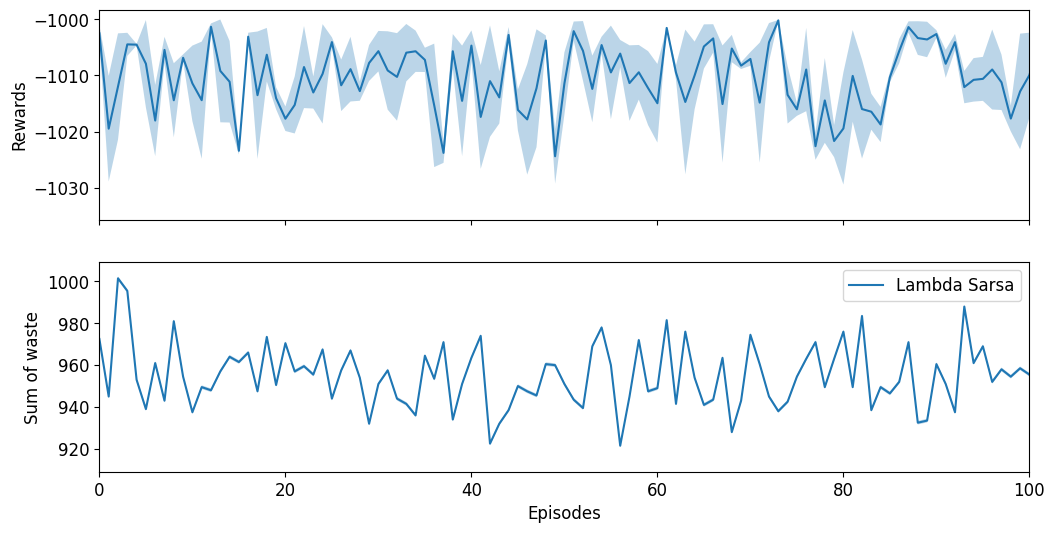

In [125]:
plot_results_rw(all_reward_sums, all_waste, algos, {'x_lim':(0, 100)})

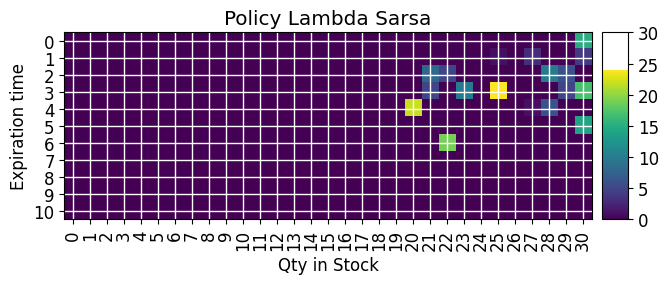

In [51]:
for algo in algos:
    plot_utils.plot_policy(all_policies[algo][-1],exp + 1, cap + 1, 0, {'title':f'Policy {algo}'})

In [312]:
class NeuralNetworkAgent:
    def __init__(self, input_dim, output_dim, hidden_dim=64):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        
        # Define the neural network architecture
        self.model = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.output_dim)
        )
        
        # Define the optimizer
        self.optimizer = optim.Adam(self.model.parameters())
        
        # Define the loss function
        self.loss_function = nn.MSELoss()
        
    def predict(self, state):
        """Predict action values for a given state."""
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            return self.model(state_tensor).squeeze().numpy()
        
    def update(self, state, action, target):
        """Update the neural network's parameters based on a single sample."""
        self.optimizer.zero_grad()
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action_tensor = torch.tensor(action, dtype=torch.float32).unsqueeze(0)
        target_tensor = torch.tensor(target, dtype=torch.float32).unsqueeze(0)
        output = self.model(state_tensor)
        loss = self.loss_function(output, target_tensor)
        loss.backward()
        self.optimizer.step()
        return loss.item()

In [367]:
cap = 30
exp = 15
env_info = {'capacity': cap,
            'initial_stock': cap,
            'maintenance_cost':0,
            'expiration_time': exp,
            'buying_price': 0.5,
            'selling_price': 1,
            'expiration_cost':0, 
            'weekly_demand':5,
            'gamma':0.925,
            'max_time':100,
            'max_loss': 100,
            'lags_to_return':7
            }


Testing the environment step by step to see if it works well

In [39]:
env = store_env.Environment
evironment_sel = env()
evironment_sel.env_init(env_info)
print(evironment_sel.env_start())
print(evironment_sel.actual_demand)
print(evironment_sel.expiration_data)

print(evironment_sel.env_step(0))
print(evironment_sel.actual_demand)
print(evironment_sel.expiration_data)

print(evironment_sel.env_step(0))
print(evironment_sel.actual_demand)
print(evironment_sel.expiration_data)

print(evironment_sel.env_step(1))
print(evironment_sel.actual_demand)
print(evironment_sel.expiration_data)

print(evironment_sel.env_step(10))
print(evironment_sel.actual_demand)
print(evironment_sel.expiration_data)

print(evironment_sel.env_step(0))
print(evironment_sel.actual_demand)
print(evironment_sel.expiration_data)

print(evironment_sel.env_step(0))
print(evironment_sel.actual_demand)
print(evironment_sel.expiration_data)
print(evironment_sel.env_step(0))
print(evironment_sel.actual_demand)
print(evironment_sel.expiration_data)
print(evironment_sel.env_step(0))
print(evironment_sel.actual_demand)
print(evironment_sel.expiration_data)

print(evironment_sel.env_step(0))
print(evironment_sel.actual_demand)
print(evironment_sel.expiration_data)



(30, 10)
0
[{'qty': 30, 'exp': 10}]
(2.7, (27, 9), False)
3
[{'qty': 27, 'exp': 9}]
(3.73, (23, 8), False)
4
[{'qty': 23, 'exp': 8}]
(7.77, (16, 7), False)
8
[{'qty': 15, 'exp': 7}, {'qty': 1, 'exp': 9}]
(0.84, (25, 6), False)
1
[{'qty': 14, 'exp': 6}, {'qty': 1, 'exp': 8}, {'qty': 10, 'exp': 9}]
(2.75, (22, 5), False)
3
[{'qty': 11, 'exp': 5}, {'qty': 1, 'exp': 7}, {'qty': 10, 'exp': 8}]
(4.78, (17, 4), False)
5
[{'qty': 6, 'exp': 4}, {'qty': 1, 'exp': 6}, {'qty': 10, 'exp': 7}]
(5.83, (11, 5), False)
6
[{'qty': 1, 'exp': 5}, {'qty': 10, 'exp': 6}]
(7.89, (3, 5), False)
8
[{'qty': 10, 'exp': 5}]
(1.97, (1, 4), False)
2
[{'qty': 8, 'exp': 4}]


## DQN

QN (Deep Q-Network) Agent
The primary agent implementing Deep Q-Learning with the following features:
- Neural network architecture for Q-value approximation
- Experience replay buffer for stable learning
- Target network for reducing overestimation bias
- ε-greedy exploration strategy

In [98]:
cap = 30
exp = 10 # days expiration per product
env_info = {'capacity': cap,
            'initial_stock': cap,
            'maintenance_cost':0.01,
            'expiration_time': exp,
            'buying_price': 0.5,
            'selling_price': 1,
            'expiration_cost':1, 
            'weekly_demand':5,
            'gamma':0.925,
            'max_time':365,
            'max_loss': 100
            }
agent_info = {"num_actions": cap + 1, 
              "num_states": (cap + 1)*(exp+1),
              "expiration": exp, 
              "epsilon": 0.1, 
              "step_size": 0.8, 
              "discount": 1.0}

In [99]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [100]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [101]:
env = store_env.Environment
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
evironment_sel = env()
evironment_sel.env_init(env_info)
n_actions = agent_info['num_actions']

state = evironment_sel.env_start()
n_observations = len(state)

In [102]:
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [91]:
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)
steps_done = 0

In [103]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([random.sample(evironment_sel.action_space,1)], device=device, dtype=torch.long)

In [104]:
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    reward_t = torch.tensor(episode_rewards, dtype=torch.float)
    waste_t = torch.tensor(episode_wastes, dtype=torch.float)
    episode_wastes_cost_t = torch.tensor(episode_wastes_cost, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    lns1 = plt.plot(durations_t.numpy(), label='Duration', color='lightblue')
    lns_waste = plt.plot(waste_t.numpy(), label='Waste', color='purple')
    lns1 = lns1 + lns_waste
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        lns_m = plt.plot(means.numpy(), label='Mean Duration', color ='#00008B')
        lns1 = lns1 + lns_m

    # Secondary y-axis for reward
    ax2 = plt.gca().twinx()
    ax2.set_ylabel('Reward')
    lns2 = ax2.plot(reward_t.numpy(), color='green', label='Reward')
    lns_waste_cost = ax2.plot(episode_wastes_cost_t.numpy(), color='black', label='Waste Cost')
    lns2 = lns2 + lns_waste_cost
    if len(reward_t) >= 100:
        means_reward = reward_t.unfold(0, 100, 1).mean(1).view(-1)
        means_reward = torch.cat((torch.zeros(99), means_reward))
        lns_r_mean = ax2.plot(means_reward.numpy(), color='darkgreen', label='Mean Reward')
        lns2 = lns2 + lns_r_mean
    # Legends
    lns = lns1+lns2
    labs = [l.get_label() for l in lns]
    plt.legend(lns, labs, loc=0)     

    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [105]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))
    # print(batch.action)
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


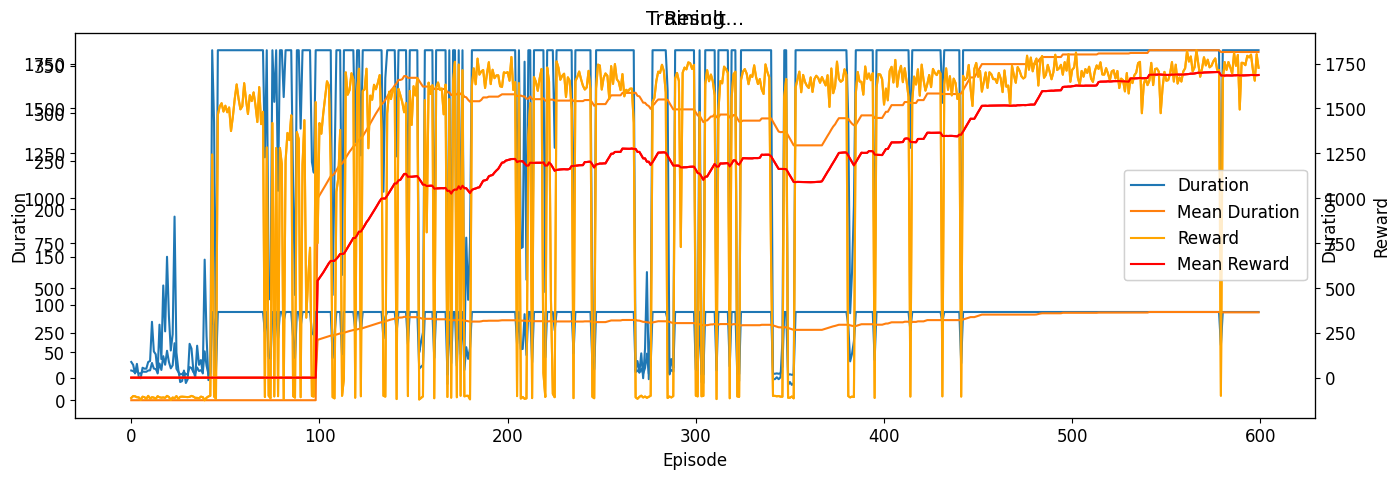

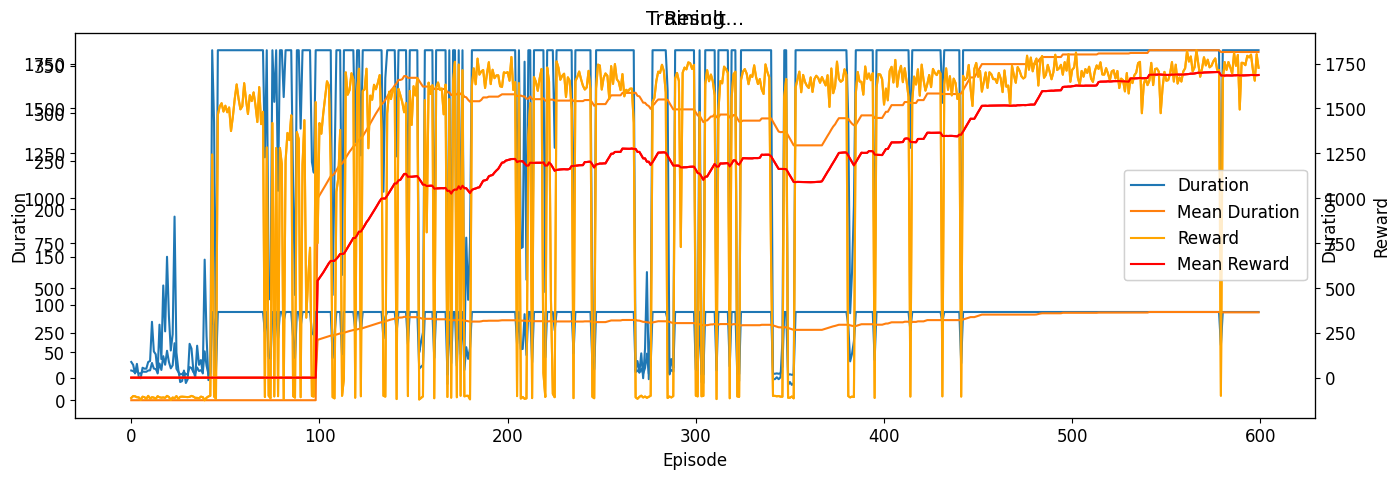

In [94]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state = evironment_sel.env_start()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    cum_reward = 0
    for t in count():
        action = select_action(state)
        reward, observation, terminated = evironment_sel.env_step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            episode_rewards.append(evironment_sel.cum_profit)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

### Get The policy

In [106]:
def get_policy(modelo, state):
    state_tensor = torch.tensor(state, dtype=torch.float32)
    with torch.no_grad():
        if hasattr(modelo, 'act'):
            action_values, probs = modelo.act(state)
            action = action_values
        else:
            action_values = modelo(state_tensor)
            action = torch.argmax(action_values).item()
    return action


In [107]:
policy_dict = {}
state_space = [(qty_instock, to_expire) for qty_instock in range(env_info['capacity'] + 1) for to_expire in range(env_info['expiration_time'] + 1)]

for state in state_space:
    # Get the policy for the current state
    action = get_policy(policy_net, state)
    # Store the policy in the dictionary
    policy_dict[state] = action

In [161]:
def get_policy_from_model(modelo, state_space):
    policy_dict = {}
    # state_space = [(qty_instock, to_expire) for qty_instock in range(env_info['capacity'] + 1) for to_expire in range(env_info['expiration_time'] + 1)]
    # print(state_space)
    for state in state_space:
        # Get the policy for the current state
        action = get_policy(modelo, state)
        # Store the policy in the dictionary
        policy_dict[state] = action
    return policy_dict

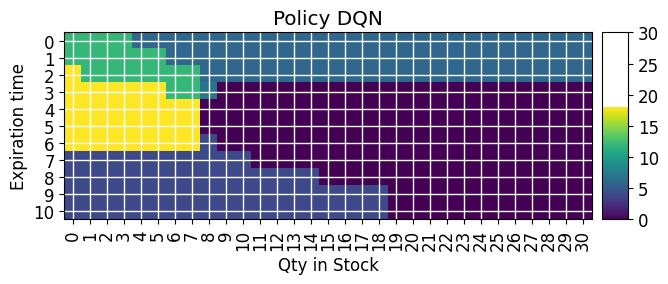

In [98]:
plot_utils.plot_policy(policy_dict,  env_info['expiration_time'] + 1,env_info['capacity'] + 1, 0, {'title':f'Policy DQN'})


From the policy learned by the DQN agent, we can conclude some logic approaches:
- For low stock quantities and high expiration time, the agent chooses to re-stock small quantities. However, when the expiration time is short, the agent prefers to restock in high quantity.

- In abundance of stock (greater than 20) and high expiration time, the agent prefer to not stock. However, when the expiration time is close to 0, it restock in small quantities.

### Other Test

#### Train function

#### Train function

In [108]:
def train(num_episodes):    
    for i_episode in range(num_episodes):
        # Initialize the environment and get its state
        state = evironment_sel.env_start()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        cum_reward = 0
        for t in count():
            action = select_action(state)
            reward, observation, terminated = evironment_sel.env_step(action.item())
            reward = torch.tensor([reward], device=device)
            done = terminated

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            optimize_model()

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                episode_durations.append(t + 1)
                episode_rewards.append(evironment_sel.cum_profit)
                episode_wastes.append(evironment_sel.total_waste)
                episode_wastes_cost.append(evironment_sel.total_waste_cost)
                plot_durations()
                break

    print('Complete')
    plot_durations(show_result=True)
    plt.ioff()
    plt.show()

Changing some environment variables

In [288]:
cap = 30
exp = 10 # days expiration per product
env_info = {'capacity': cap,
            'initial_stock': cap,
            'maintenance_cost':0.01,
            'expiration_time': exp,
            'buying_price': 0.5,
            'selling_price': 1,
            'expiration_cost':1, 
            'weekly_demand':5,
            'gamma':0.925,
            'max_time':365,
            'max_loss': 200
            }
agent_info = {"num_actions": cap + 1, 
              "num_states": (cap + 1)*(exp+1),
              "expiration": exp, 
              "epsilon": 0.1, 
              "step_size": 0.8, 
              "discount": 1.0}

In [120]:

env = store_env.Environment
BATCH_SIZE = 128
GAMMA = 0.95
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.0005
LR = 1e-4
evironment_sel = env()
evironment_sel.env_init(env_info)
n_actions = agent_info['num_actions']

state = evironment_sel.env_start()
n_observations = len(state)
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)
steps_done = 0
episode_durations = []
episode_rewards = []
episode_wastes = []
episode_wastes_cost = []

In [233]:
torch.save(policy_net.state_dict(), 'results/dqn.pt')

Complete


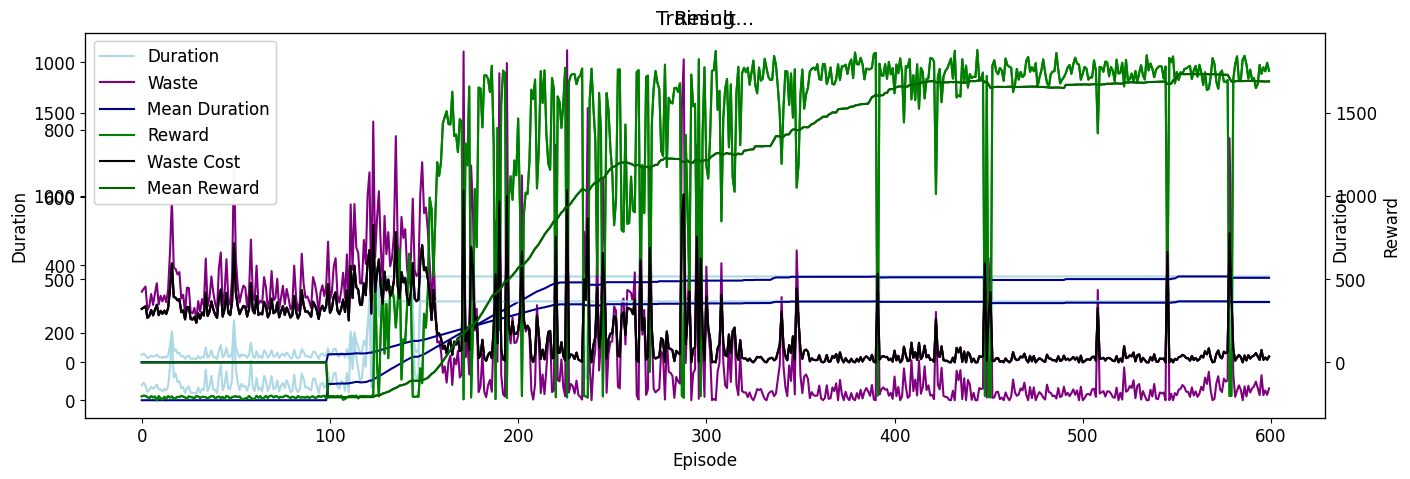

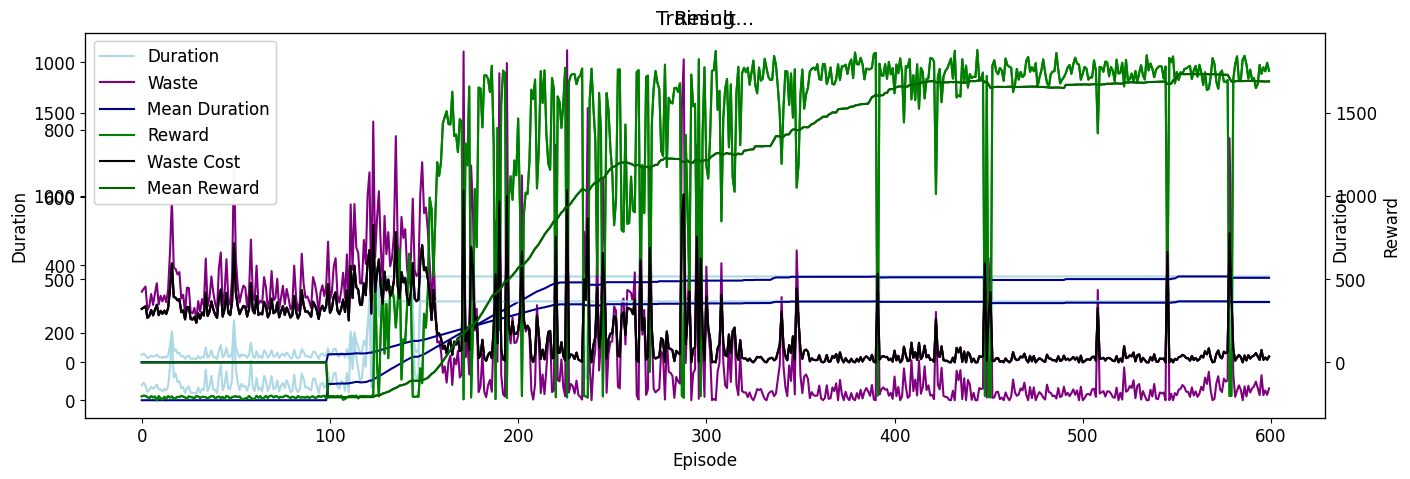

In [121]:
train(600)

In [122]:
data_dict = {
    'episode_durations': episode_durations,
    'episode_rewards': episode_rewards,
    'episode_wastes': episode_wastes,
    'episode_wastes_cost': episode_wastes_cost
}

# Save the dictionary into a file
np.save('results/dqn_base.npy', data_dict)

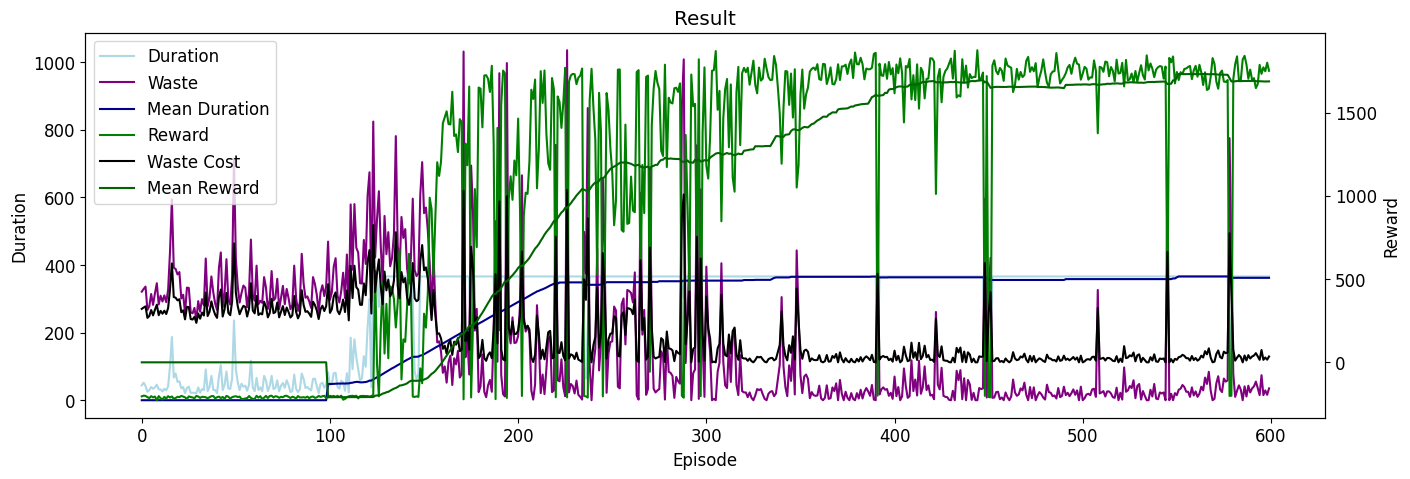

In [125]:
plot_durations(True)

In [109]:
def plot_results_dqn(episode_durations, episode_rewards, episode_wastes, episode_wastes_cost):
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    reward_t = torch.tensor(episode_rewards, dtype=torch.float)
    waste_t = torch.tensor(episode_wastes, dtype=torch.float)
    episode_wastes_cost_t = torch.tensor(episode_wastes_cost, dtype=torch.float)
    pastel_blue = '#ADD8E6'
    pastel_purple = '#B19CD9'
    pastel_green = '#77DD77'
    pastel_darkgreen = '#3D9970'

    means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(99), means))

    means_reward = reward_t.unfold(0, 100, 1).mean(1).view(-1)
    means_reward = torch.cat((torch.zeros(99), means_reward))
    variance_reward = reward_t.unfold(0, 100, 1).var(1).view(-1)
    variance_reward = torch.cat((torch.zeros(99), variance_reward))
    stderr_reward = reward_t.unfold(0, 100, 1).std(1).view(-1) / np.sqrt(100)
    stderr_reward = torch.cat((torch.zeros(99), stderr_reward))
    
    # data_mean = np.mean(data, axis=0)
    # data_std_err = np.std(data, axis=0)/np.sqrt(len(data))

    means_waste = waste_t.unfold(0, 100, 1).mean(1).view(-1)
    means_waste = torch.cat((torch.zeros(99), means_waste))
    variance_waste = waste_t.unfold(0, 100, 1).var(1).view(-1)
    variance_waste = torch.cat((torch.zeros(99), variance_waste))
    stderr_waste = waste_t.unfold(0, 100, 1).std(1).view(-1) / np.sqrt(100)
    stderr_waste = torch.cat((torch.zeros(99), stderr_waste))

    means_wastes_cost = episode_wastes_cost_t.unfold(0, 100, 1).mean(1).view(-1)
    means_wastes_cost = torch.cat((torch.zeros(99), means_wastes_cost))
    
    l1 = plt.plot(means_waste.numpy(), label = 'Mean Waste', color= pastel_purple)

    plt.fill_between(range(len(stderr_waste)), means_waste - stderr_waste, means_waste + stderr_waste, color=pastel_purple, alpha=0.3)
    
    plt.ylabel('Mean Waste')
    plt.xlabel('Episode')

    ax2 = plt.gca().twinx()
    ax2.set_ylabel('Mean Reward')
    l2  = ax2.plot(means_reward.numpy(), label='Mean Reward', color=pastel_green)
    ax2.fill_between(range(len(stderr_reward)), means_reward - stderr_reward, means_reward + stderr_reward, color=pastel_green, alpha=0.3)


    lines_ = l1 + l2
    labs = [l.get_label() for l in lines_]
    plt.legend(lines_, labs, loc=0)  
    plt.title('Mean Waste and Mean Reward over Episodes')
    plt.show()

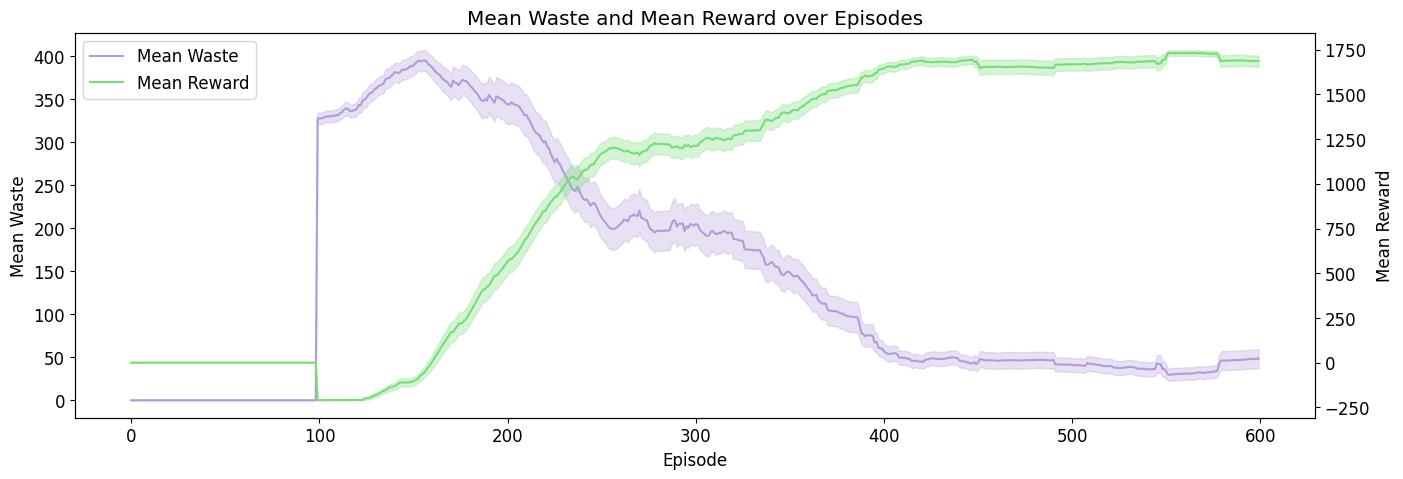

In [380]:
plot_results_dqn(episode_durations, episode_rewards, episode_wastes, episode_wastes_cost)

In [ ]:
env_info = {'capacity': 50,
            'initial_stock': 50,
            'maintenance_cost':0.1,
            'expiration_time': 10,
            'buying_price': 0.5,
            'selling_price': 1,
            'expiration_cost':2, 
            'weekly_demand':5,
            'gamma':0.925,
            'max_time':365,
            'max_loss': 100
            }
agent_info = {"num_actions": env_info['capacity'] + 1, 
              "num_states": (env_info['capacity'] + 1)*(env_info['expiration_time']+1),
              "epsilon": 0.1, 
              "step_size": 0.8, 
              "discount": 1.0}

In [93]:
env = store_env.Environment
BATCH_SIZE = 128
GAMMA = 0.95
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.0005
LR = 1e-4
evironment_sel = env()
evironment_sel.env_init(env_info)
n_actions = agent_info['num_actions']

state = evironment_sel.env_start()
n_observations = len(state)
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)
steps_done = 0
episode_durations = []
episode_rewards = []
episode_wastes = []
episode_wastes_cost = []

Complete


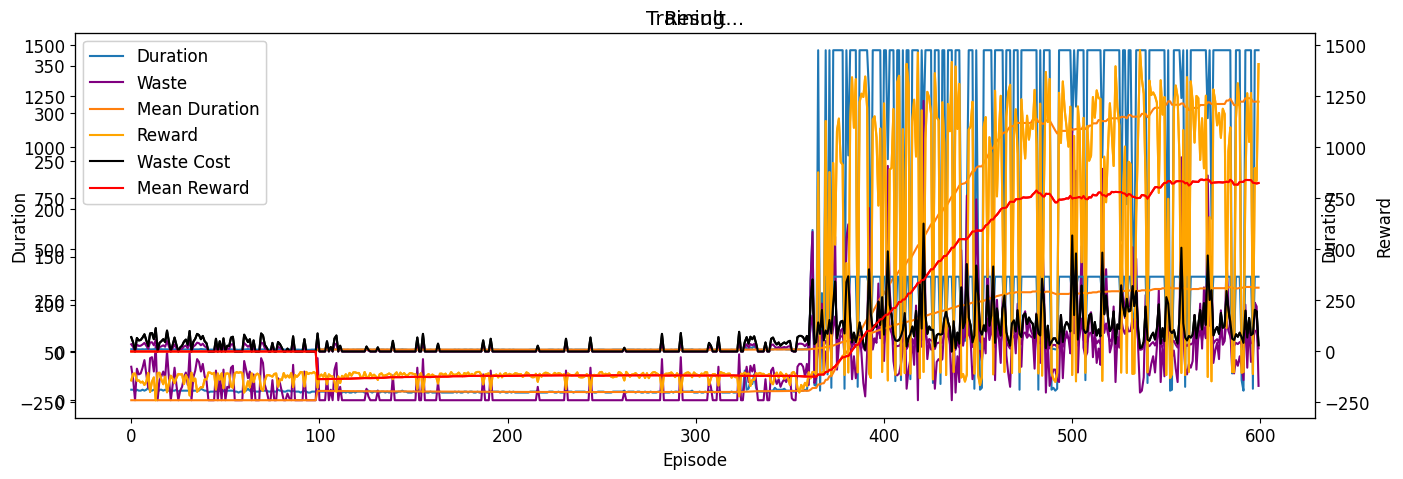

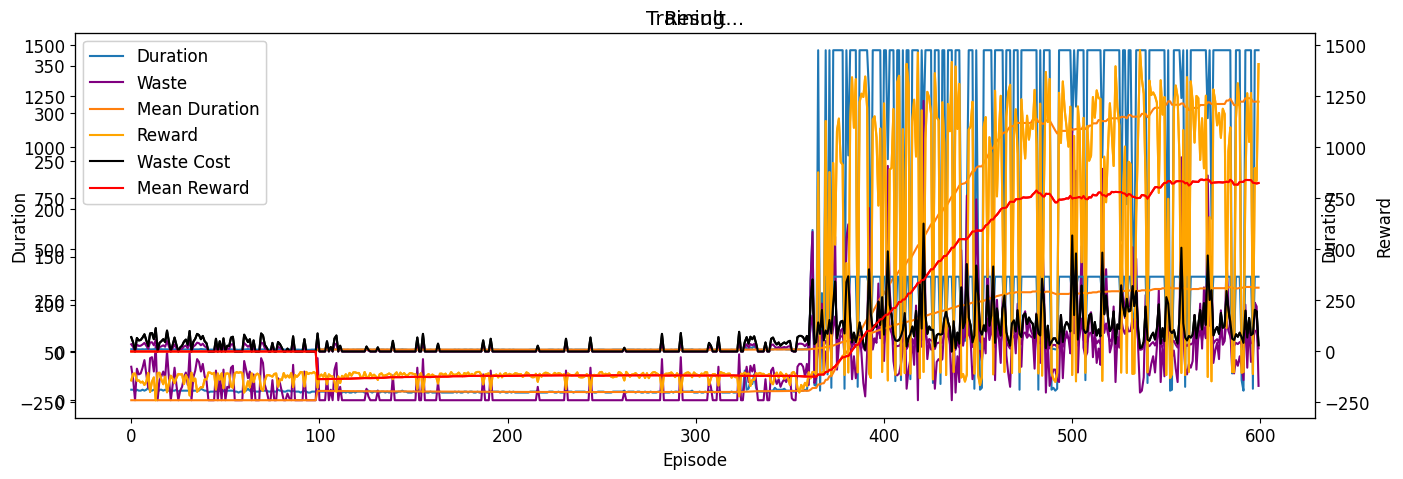

In [94]:
train(600)

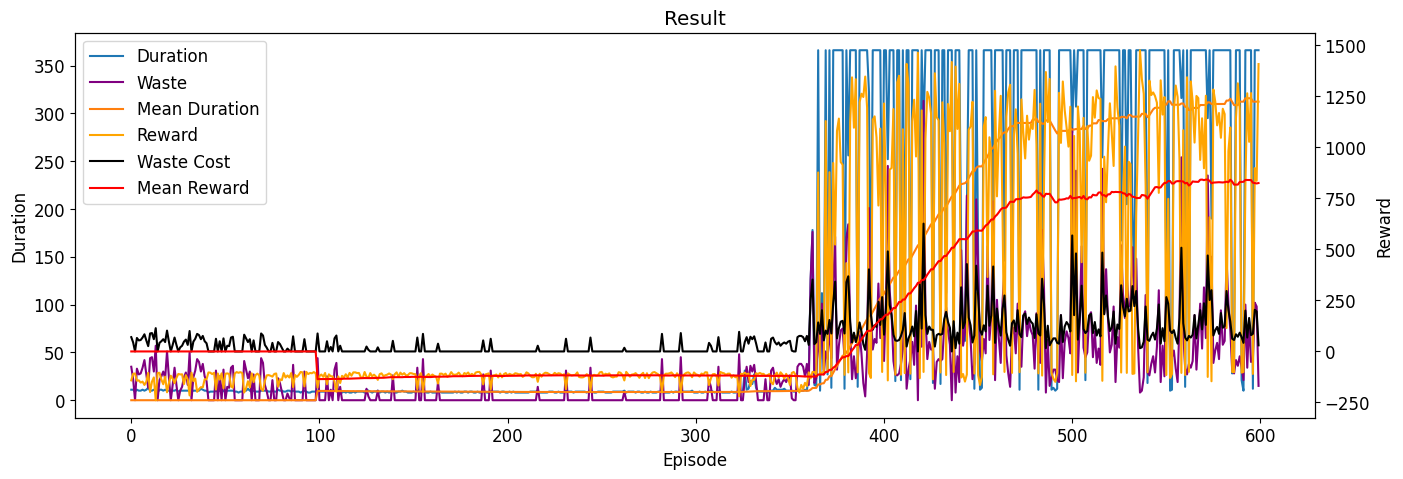

In [95]:
plot_durations(True)

In [96]:
state_space = [(qty_instock, to_expire) for qty_instock in range(env_info['capacity'] + 1) for to_expire in range(env_info['expiration_time'] + 1)]
policy_v2 = get_policy_from_model(state_space)

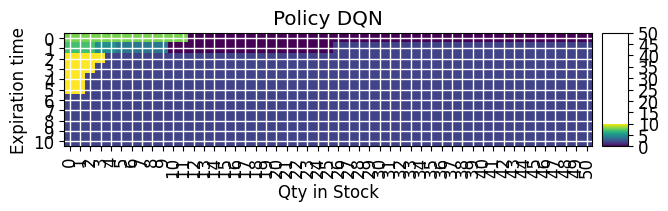

In [98]:
plot_utils.plot_policy(policy_v2,  env_info['expiration_time'] + 1,env_info['capacity'] + 1, 0, {'title':f'Policy DQN'})


Complete


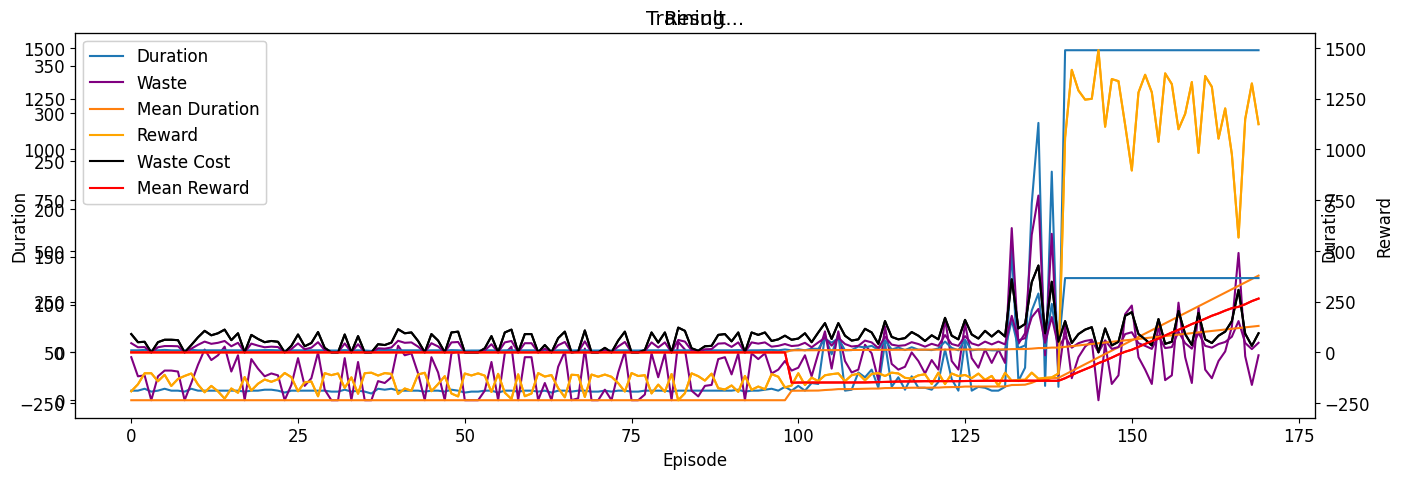

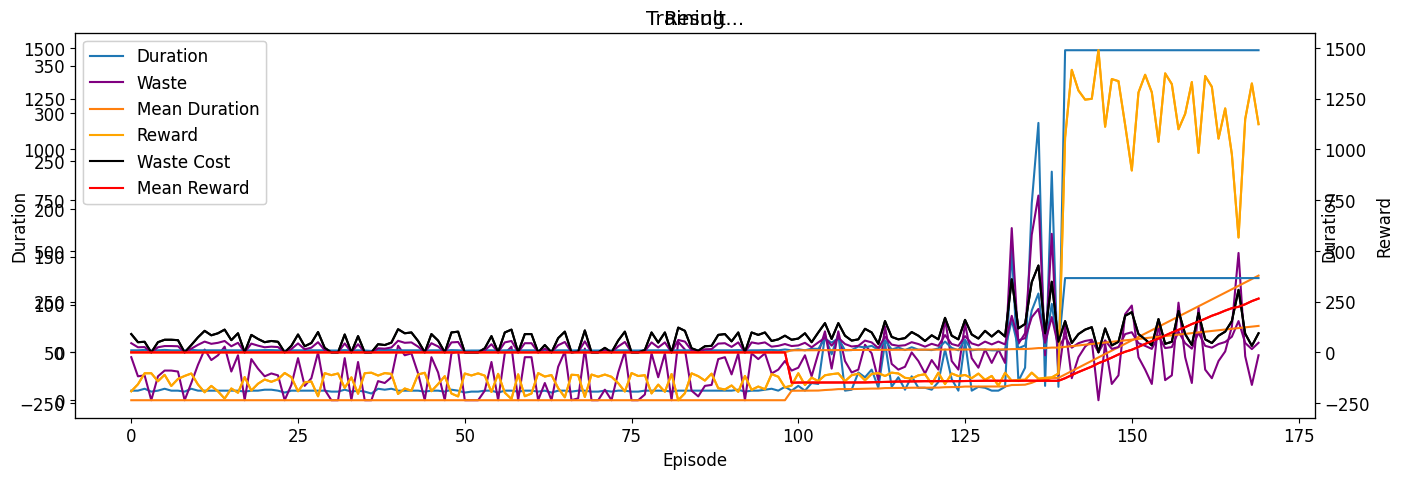

In [76]:
train(170)

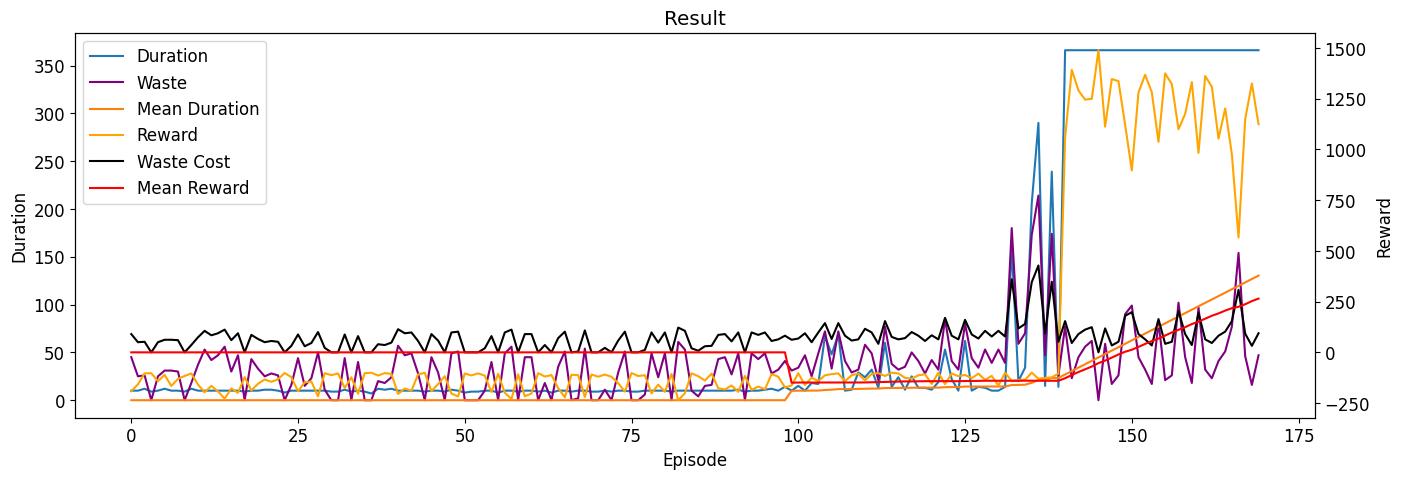

In [77]:
plot_durations(True)

In [78]:
policy_v3 = get_policy_from_model(state_space)

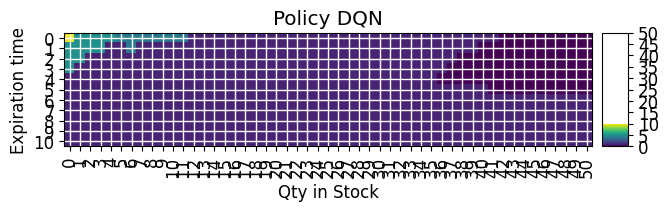

In [81]:
plot_utils.plot_policy(policy_v3,  env_info['expiration_time'] + 1, env_info['capacity'] + 1, 0, {'title':f'Policy DQN'})


## Reinforce approach

In [113]:
class Policy(nn.Module):
    def __init__(self, state_size=4, action_size=2, hidden_size=32):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, action_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        # we just consider 1 dimensional probability of action
        return F.softmax(x, dim=1)
    
    def act(self, state):
        # print(state)
        state = np.array(state)
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        # print(state)
        probs = self.forward(state).cpu()
        # print(probs.shape)
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)

In [114]:
def reinforce(policy, optimizer, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100, target_score=1500):
    scores_deque = deque(maxlen=100)
    scores = []
    wastes = []
    for e in range(1, n_episodes):
        saved_log_probs = []
        rewards = []
        
        state = evironment_sel.env_start()
        # Collect episode data
        for t in range(max_t):
            # Sample the action from current policy
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            reward, state, done  = evironment_sel.env_step(action)
            rewards.append(reward)
            if done:
                break
        # Calculate total expected reward
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        wastes.append(evironment_sel.total_waste)
        
        # Recalculate the total reward applying discounted factor
        discounts = [gamma ** i for i in range(len(rewards) + 1)]
        R = sum([a * b for a,b in zip(discounts, rewards)])
        # print(R)
        # Calculate the loss 
        policy_loss = []
        for log_prob in saved_log_probs:
            # Note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.
            policy_loss.append(-log_prob * R)
        # After that, we concatenate whole policy loss in 0th dimension
        policy_loss = torch.cat(policy_loss).sum()
        
        # Backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if e % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))

        if len(scores_deque)>99 and np.mean(scores_deque) >= target_score:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e - 100, np.mean(scores_deque)))
            break
    return scores, wastes

In [336]:
evironment_sel = env()
evironment_sel.env_init(env_info)
n_actions = agent_info['num_actions']
policy = Policy(2, n_actions, 64).to(device)
optimizer = optim.AdamW(policy.parameters(), lr=1e-3)
scores, wastes = reinforce(policy, optimizer, n_episodes=10000,target_score=1300)

Episode 100	Average Score: 1630.35
Environment solved in 0 episodes!	Average Score: 1630.35


In [294]:
torch.save(policy.state_dict(), 'results/model_reinforce.pt')

In [337]:
policy_reinf = get_policy_from_model(policy,state_space)

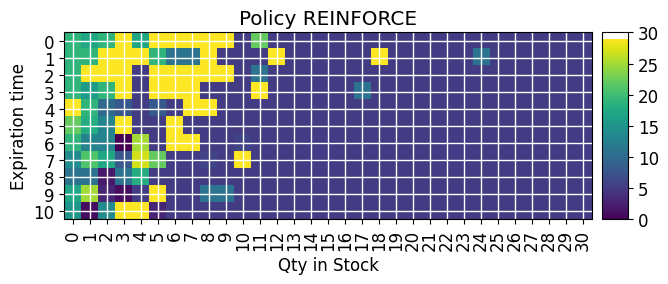

In [338]:
plot_utils.plot_policy(policy_reinf,  env_info['expiration_time'] + 1,env_info['capacity'] + 1, 0, {'title':f'Policy REINFORCE'})


### Reinforce Agent

In [117]:
# Reinforcement agent
class ReinforceAgent(agent.BaseAgent):
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.states_dim = agent_init_info.get("states_dim",2)
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_init_info.get("seed", 0))
        
        # Create an array for action-value estimates and initialize it to zero.
        # self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.
        self.q = defaultdict(lambda: np.zeros(self.num_actions)) # The array of action-value estimates.
        self.policy_net = DQN(self.states_dim, self.num_actions).to(device)

        self.steps_done = 0

        # Load statedict if given
        if(agent_init_info["state_dic"]):
            self.policy_net.load_state_dict(agent_init_info["state_dic"])
    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[state]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """

        sample = self.rand_generator.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                action = self.policy_net(state).max(1).indices.view(1, 1)
        else:
            action = self.rand_generator.randint(self.num_actions)
        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode (1 line)
        pass

## DQN Agent

In [112]:
# DQN agent
class DQNAgent(agent.BaseAgent):
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.states_dim = agent_init_info.get("states_dim",2)
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_init_info.get("seed", 0))
        
        # Create an array for action-value estimates and initialize it to zero.
        # self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.
        self.q = defaultdict(lambda: np.zeros(self.num_actions)) # The array of action-value estimates.
        self.policy_net = DQN(self.states_dim, self.num_actions).to(device)

        self.steps_done = 0

        # Load statedict if given
        if(agent_init_info["state_dic"]):
            state_dict_loaded = torch.load(agent_init_info["state_dic"])
            self.policy_net.load_state_dict(state_dict_loaded)
    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        sample = self.rand_generator.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                action = self.policy_net(state).max(1).indices.view(1, 1)
        else:
            action = self.rand_generator.randint(self.num_actions)
        return action
    
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        sample = self.rand_generator.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                action = self.policy_net(state).max(1).indices.view(1, 1)
        else:
            action = self.rand_generator.randint(self.num_actions)
        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode (1 line)
        pass

## Comparison

In [128]:
agents = {
    "DQN": DQNAgent,
    "REINFORCE": ReinforceAgent
}
cap = 30
exp = 10 # days expiration per product
env_info = {'capacity': cap,
            'initial_stock': cap,
            'maintenance_cost':0.01,
            'expiration_time': exp,
            'buying_price': 0.5,
            'selling_price': 1,
            'expiration_cost':1, 
            'weekly_demand':5,
            'gamma':0.925,
            'max_time':365,
            'max_loss': 200
            }
agent_info = {
            'DQN':
                {"num_actions": cap + 1, 
                "num_states": (cap + 1)*(exp+1),
                "epsilon": 0.1, 
                "step_size": 0.8, 
                "discount": 1.0,
                'state_dic': 'results/dqn.pt',
                },
            'REINFORCE':
                {"num_actions": cap + 1, 
                "num_states": (cap + 1)*(exp+1),
                "epsilon": 0.1, 
                "step_size": 0.8, 
                "discount": 1.0,
                'state_dic': 'results/model_reinforce.pt'
                }
              }

algos = ['DQN', 'REINFORCE']
algos = ['DQN']
env = store_env.Environment

In [207]:
def run_episodes(num_runs, num_episodes, algos, agent_info, env_info):
    all_reward_sums = {} # Contains sum of rewards during episode
    all_state_visits = {} # Contains state visit counts during the last 10 episodes
    all_policies = {}
    all_waste ={}

    for algorithm in algos:
        all_reward_sums[algorithm] = []
        all_state_visits[algorithm] = []
        all_policies[algorithm] = []
        all_waste[algorithm] = []
        for run in tqdm(range(num_runs)):
            agent_info["seed"] = run
            rl_glue = RLGlue(env, agents[algorithm])
            rl_glue.rl_init(agent_info[algorithm], env_info)
            reward_sums = []
            waste_sums = []
            state_visits = defaultdict(lambda: np.zeros(rl_glue.agent.num_actions))
            for episode in range(num_episodes):
                rl_glue.rl_episode(0)                
                # state = next_state
                reward_sums.append(rl_glue.rl_return().item() if isinstance(rl_glue.rl_return(), torch.Tensor) else rl_glue.rl_return())
                waste_sums.append(rl_glue.environment.total_waste.item() if isinstance(rl_glue.environment.total_waste, torch.Tensor) else rl_glue.environment.total_waste)
            # all_policies[algorithm].append(policy)
            all_reward_sums[algorithm].append(reward_sums)
            all_state_visits[algorithm].append(state_visits)
            all_waste[algorithm].append(waste_sums)
    return all_reward_sums, all_waste, all_state_visits

In [ ]:
def plot_results_rw(all_reward_sums,all_waste_sums, algos, args={}):
    fig, ax  = plt.subplots(2, 1, figsize=(12, 6*len(algos)), sharex='all')
    ax = ax.flatten()
    x_lim = args.get('x_lim', None)
    for algorithm in algos:
        x_l = range(len(all_reward_sums[algorithm][0]))
        mean_val = np.mean(all_reward_sums[algorithm], axis=0)
        print(mean_val)
        std_val = sem(all_reward_sums[algorithm], axis=0)
        ax[0].plot(x_l, mean_val, label=algorithm)
        ax[0].fill_between(x_l,mean_val - std_val, mean_val + std_val, alpha=0.3)
        ax[0].set_ylabel("Rewards")
        ax[0].set_xlim(x_lim)
        # ax2 = plt.twinx()
        waste_avg = np.mean(all_waste_sums[algorithm], axis=0)
        std_waste = sem(waste_avg, axis=0)
        ax[1].plot(waste_avg, label=algorithm)
        ax[1].fill_between(x_l,waste_avg - std_waste, waste_avg + std_waste, alpha=0.3)
        ax[1].set_ylabel('Sum of waste')
    plt.legend()
    plt.show()

In [168]:
all_waste['DQN'] = [[a.item() if isinstance(a, torch.Tensor) else a for a in r] for r in all_waste['DQN']]

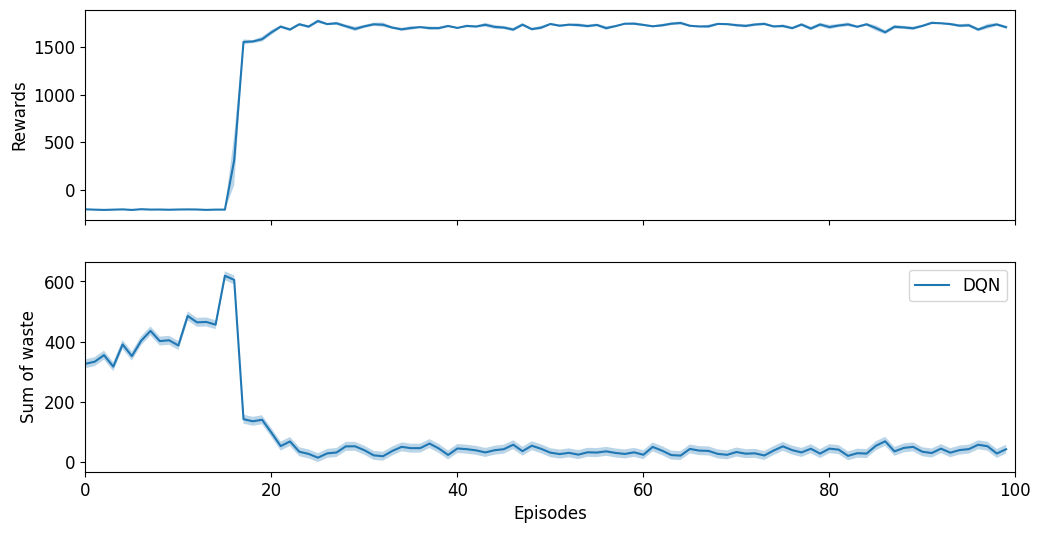

In [173]:
plot_results_rw(all_reward_sums, all_waste, algos, {'x_lim':(0, 100)})

### Performance by cost of waste

In [206]:
num_runs = 10
num_episodes = 100
env_info = {'capacity': cap,
            'initial_stock': cap,
            'maintenance_cost':0.01,
            'expiration_time': exp,
            'buying_price': 0.5,
            'selling_price': 1,
            'expiration_cost':1, 
            'weekly_demand':5,
            'gamma':0.925,
            'max_time':365,
            'max_loss': 200
            }
algos = ['DQN']

In [ ]:
# Using the same policy and changing the cost of wasting
cost_waste = [0, 1,2,3,4]
exp_rewards = []
exp_wastes = []

In [ ]:
for wc in cost_waste:
    env_info['expiration_cost'] = wc
    all_reward_sums, all_waste, all_state_visits = \
                    run_episodes(num_runs, num_episodes, algos, agent_info, env_info)
    exp_rewards.append(all_reward_sums)
    exp_wastes.append(all_waste)

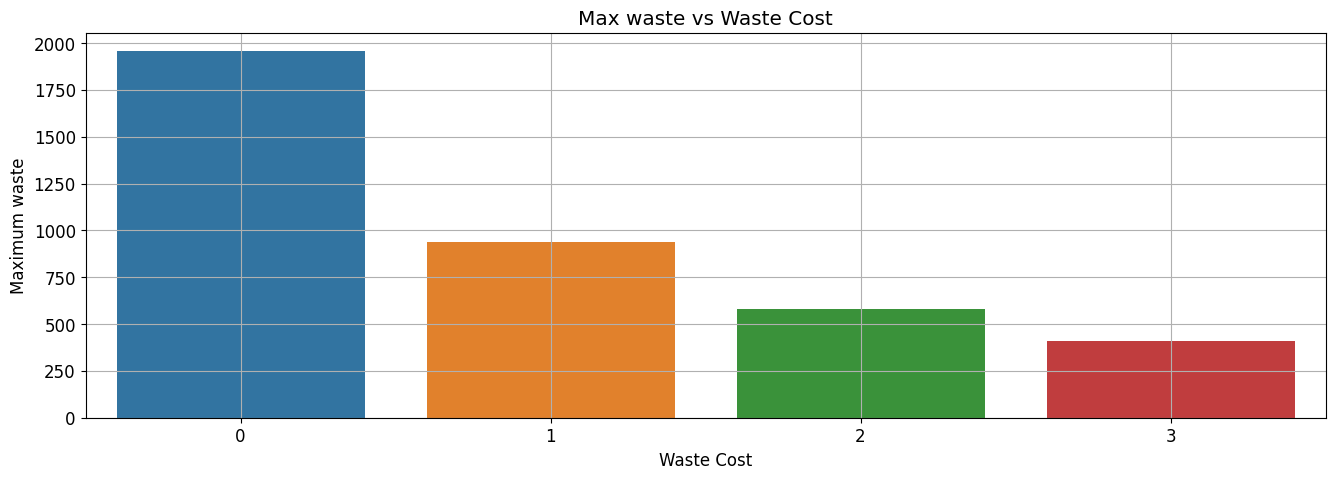

In [205]:
sns.barplot(x = cost_waste[:-1], y = [np.max(exp_wastes[i]['DQN']) for i in cost_waste[:-1]])
plt.xlabel('Waste Cost')
plt.ylabel('Maximum waste')
plt.title('Max waste vs Waste Cost')
plt.grid()
plt.show()

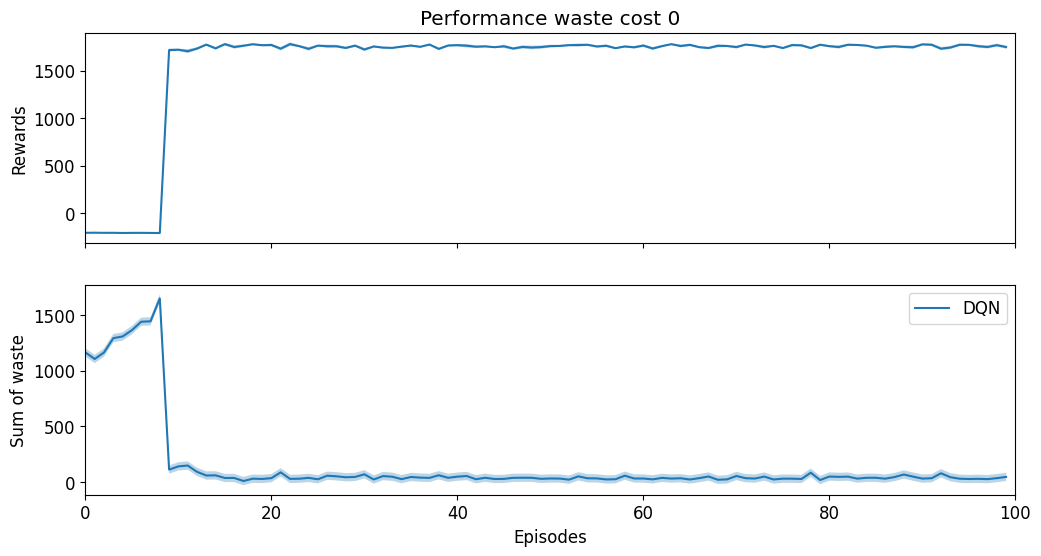

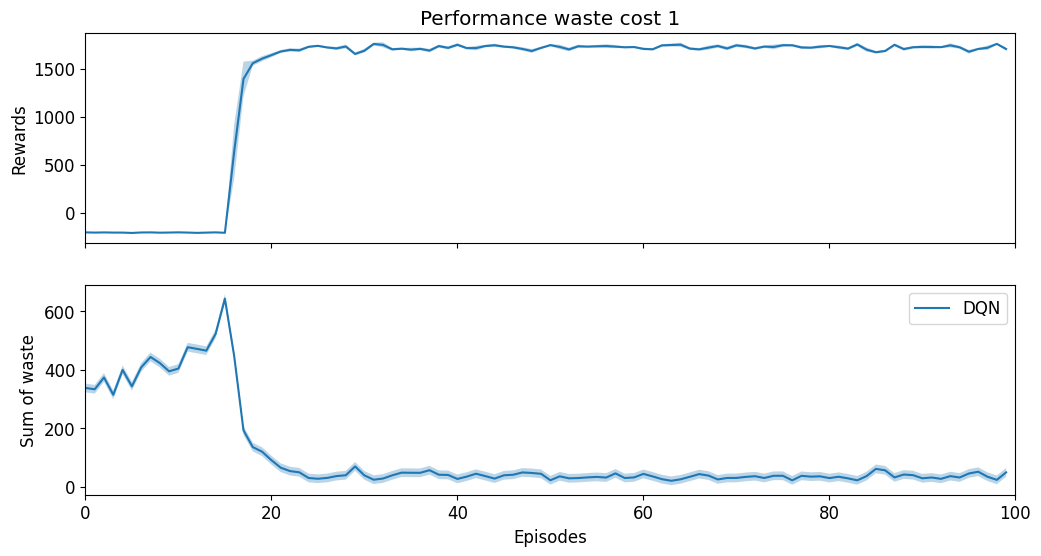

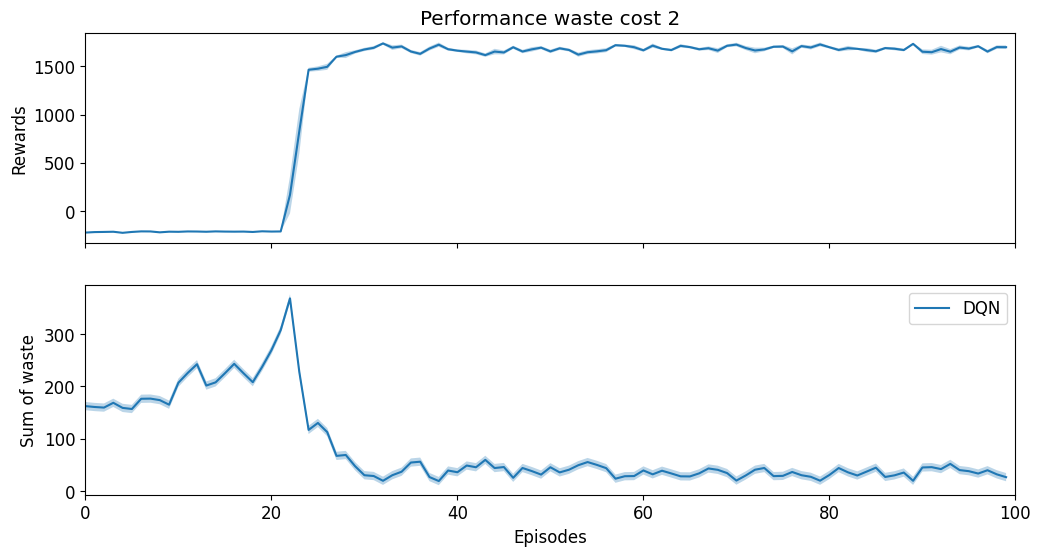

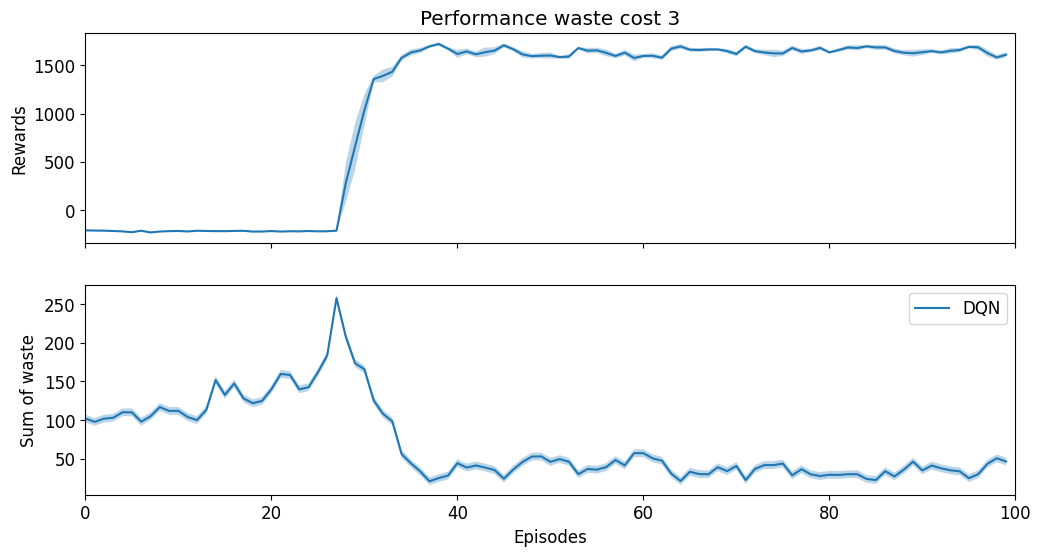

In [198]:
for i,wc in enumerate(cost_waste[:-1]):
    plot_results_rw(exp_rewards[i], exp_wastes[i], algos, {'x_lim':(0, 100), 'title': f'Performance waste cost {wc}'})

## Product price impact

In [208]:
# Using the same policy and changing the cost of wasting
selling_prices = [1,2,3,4]
env_info['expiration_cost'] = 1
sp_rewards = []
sp_wastes = []
for sp in selling_prices:
    env_info['selling_price'] = sp
    all_reward_sums, all_waste, all_state_visits = \
                    run_episodes(num_runs, num_episodes, algos, agent_info, env_info)
    sp_rewards.append(all_reward_sums)
    sp_wastes.append(all_waste)

100%|██████████| 10/10 [02:54<00:00, 17.41s/it]


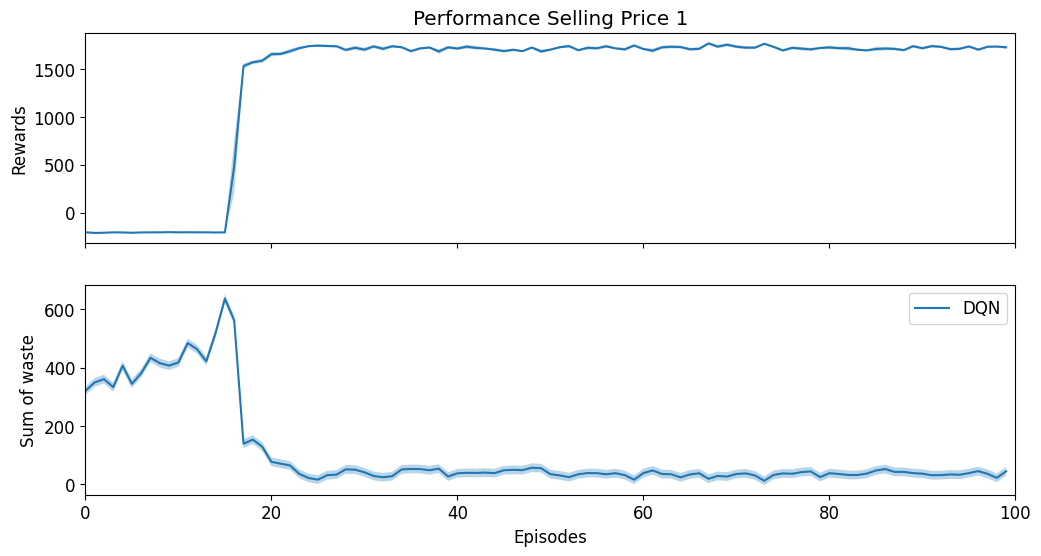

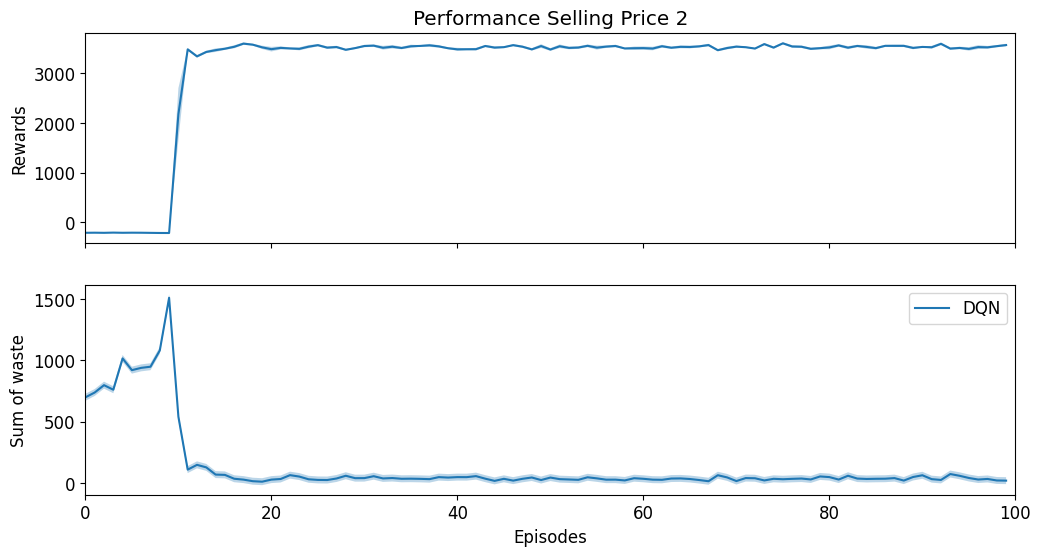

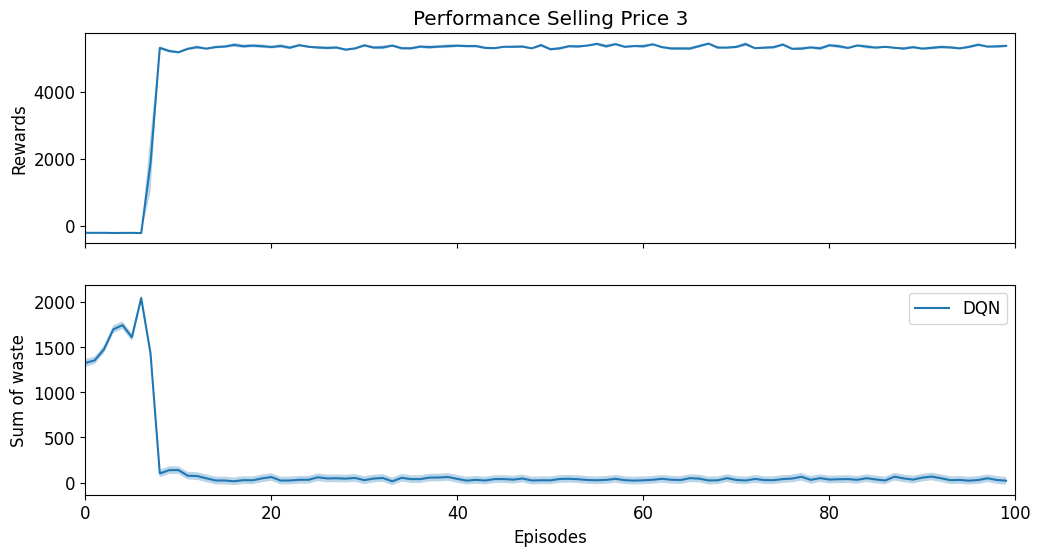

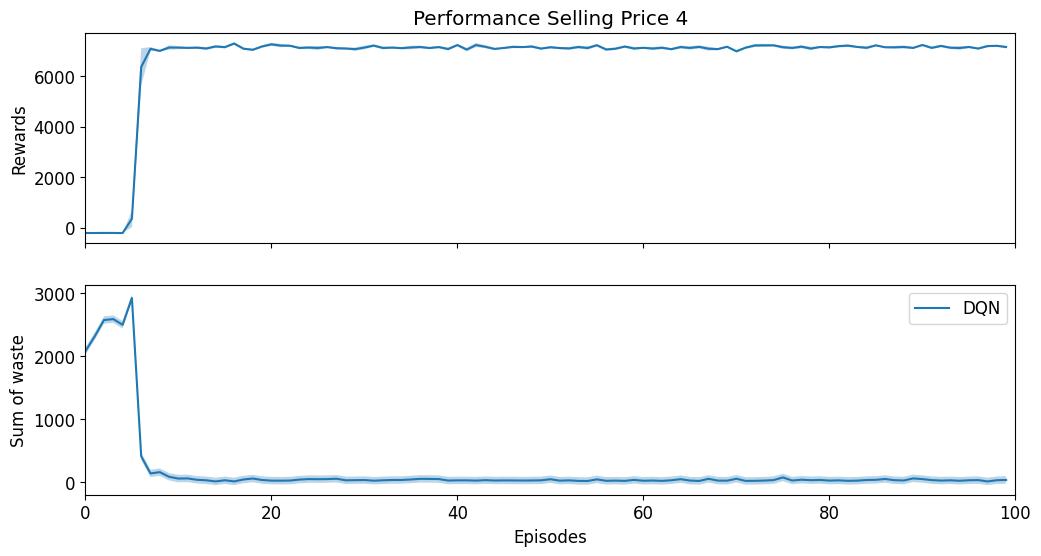

In [209]:
for i,wc in enumerate(selling_prices):
    plot_results_rw(sp_rewards[i], sp_wastes[i], algos, {'x_lim':(0, 100), 'title': f'Performance Selling Price {wc}'})

In [214]:
[np.mean(sp_wastes[i]['DQN']) for i in range(len(selling_prices))]

[958, 1839, 2533, 3268]

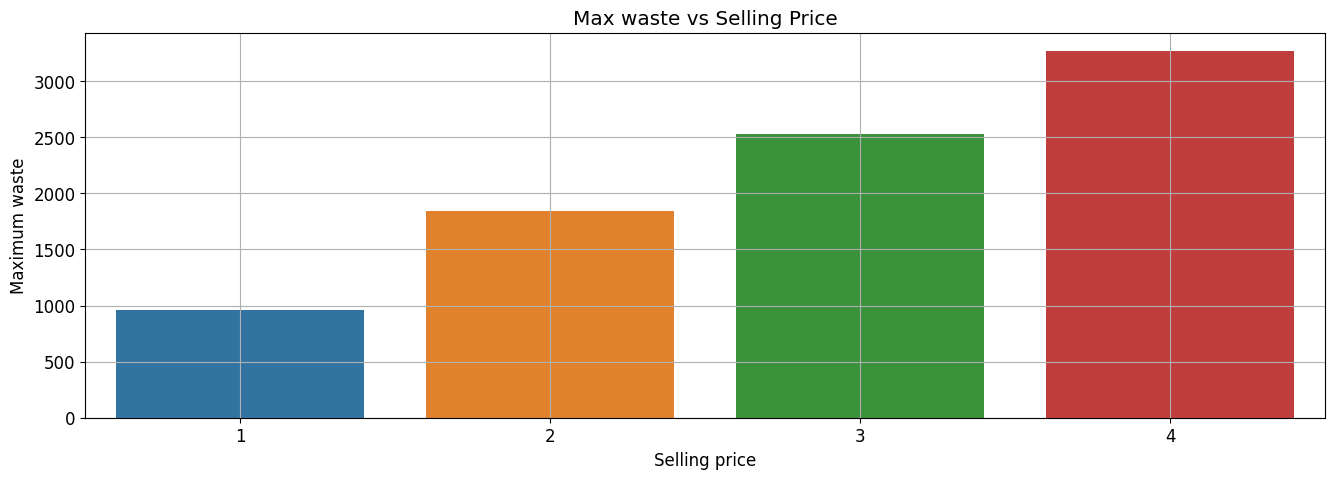

In [215]:
sns.barplot(x = selling_prices, y = [np.max(sp_wastes[i]['DQN']) for i in range(len(selling_prices))])
plt.xlabel('Selling price')
plt.ylabel('Maximum waste')
plt.title('Max waste vs Selling Price')
plt.grid()
plt.show()

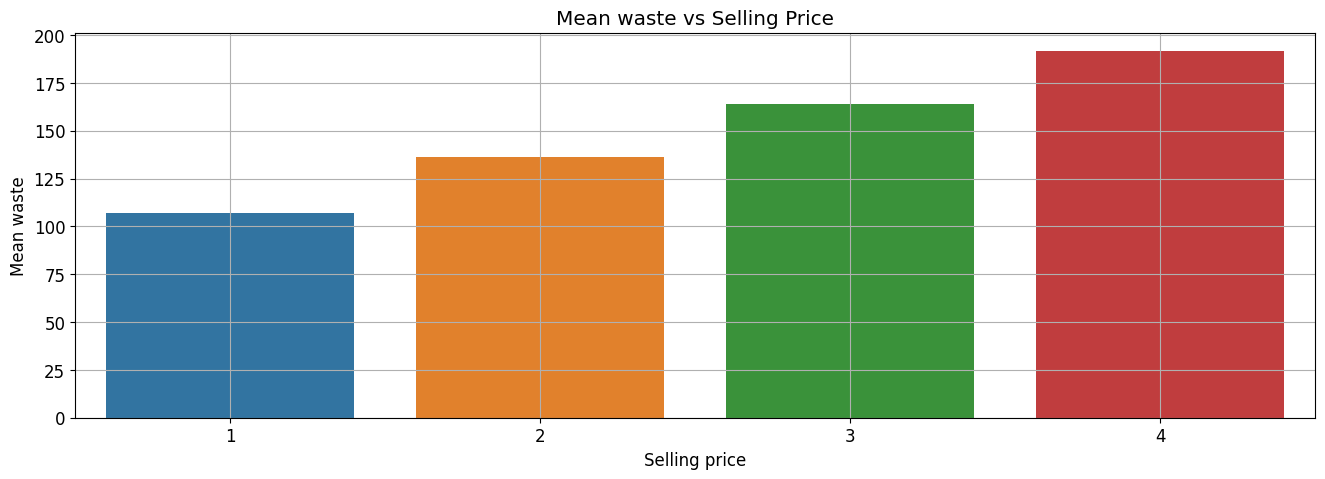

In [217]:
sns.barplot(x = selling_prices, y = [np.mean(sp_wastes[i]['DQN']) for i in range(len(selling_prices))])
plt.xlabel('Selling price')
plt.ylabel('Mean waste')
plt.title('Mean waste vs Selling Price')
plt.grid()
plt.show()

## Demand Impact

In [218]:
# Using the same policy and changing the cost of wasting
demands = [1,5, 10, 20 ]
env_info['expiration_cost'] = 1
env_info['selling_price'] = 1
d_rewards = []
d_wastes = []
for d in demands:
    env_info['weekly_demand'] = d
    all_reward_sums, all_waste, all_state_visits = \
                    run_episodes(num_runs, num_episodes, algos, agent_info, env_info)
    d_rewards.append(all_reward_sums)
    d_wastes.append(all_waste)

100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


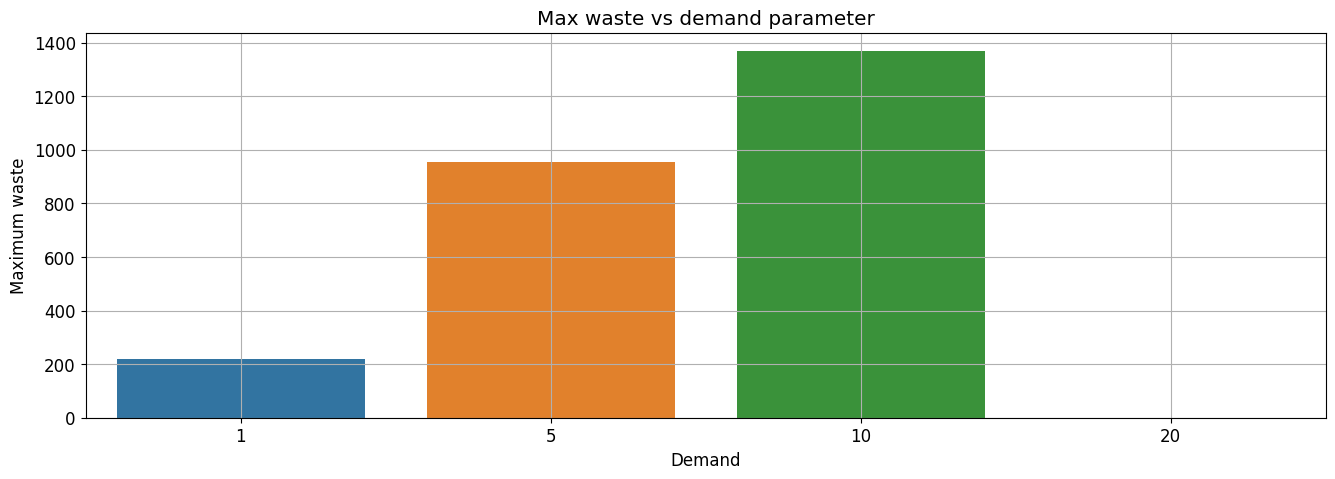

In [219]:
sns.barplot(x = demands, y = [np.max(d_wastes[i]['DQN']) for i in range(len(demands))])
plt.xlabel('Demand')
plt.ylabel('Maximum waste')
plt.title('Max waste vs demand parameter')
plt.grid()
plt.show()

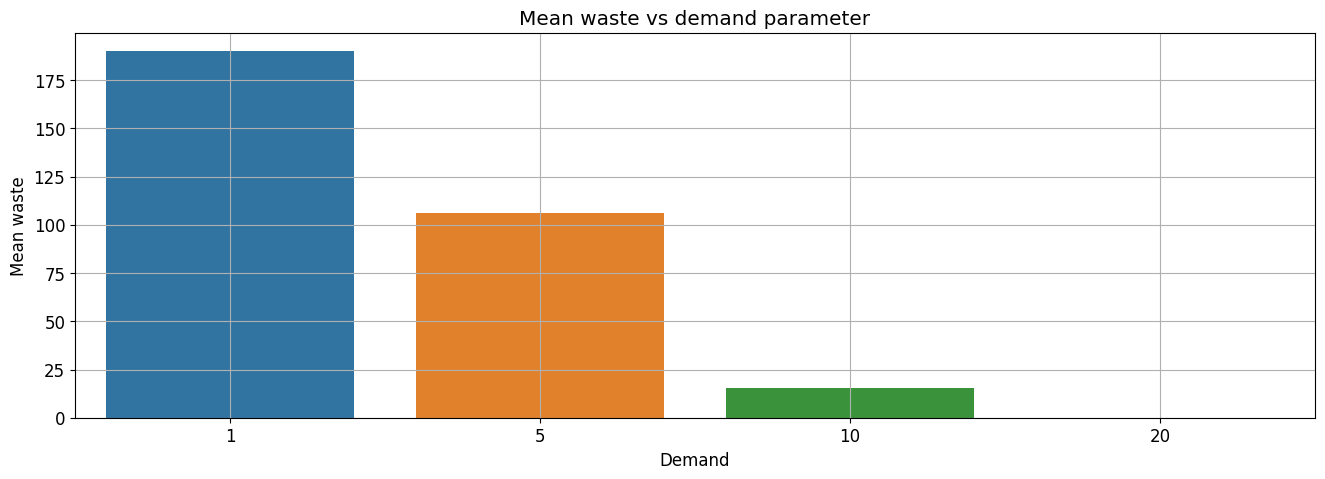

In [220]:
sns.barplot(x = demands, y = [np.mean(d_wastes[i]['DQN']) for i in range(len(demands))])
plt.xlabel('Demand')
plt.ylabel('Mean waste')
plt.title('Mean waste vs demand parameter')
plt.grid()
plt.show()

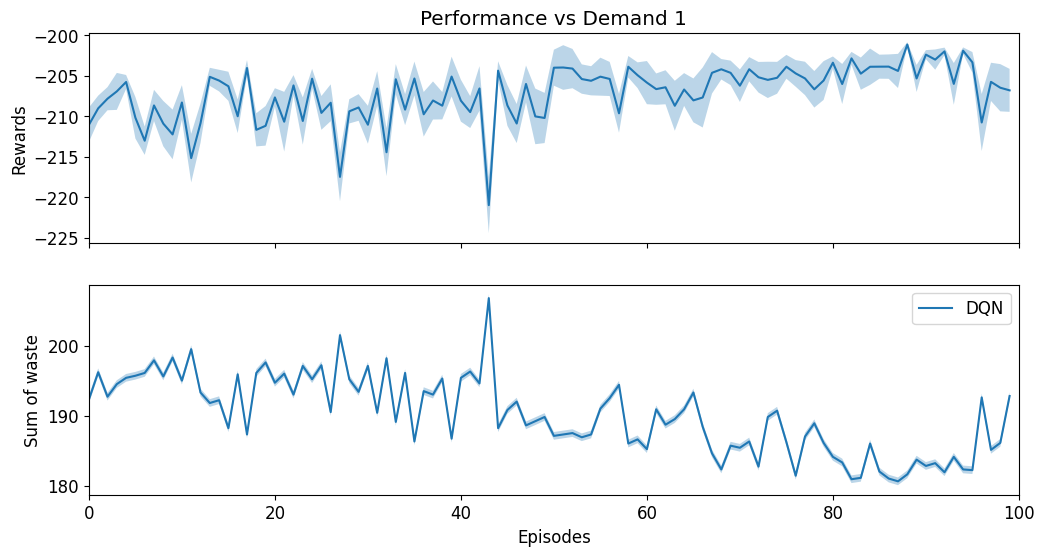

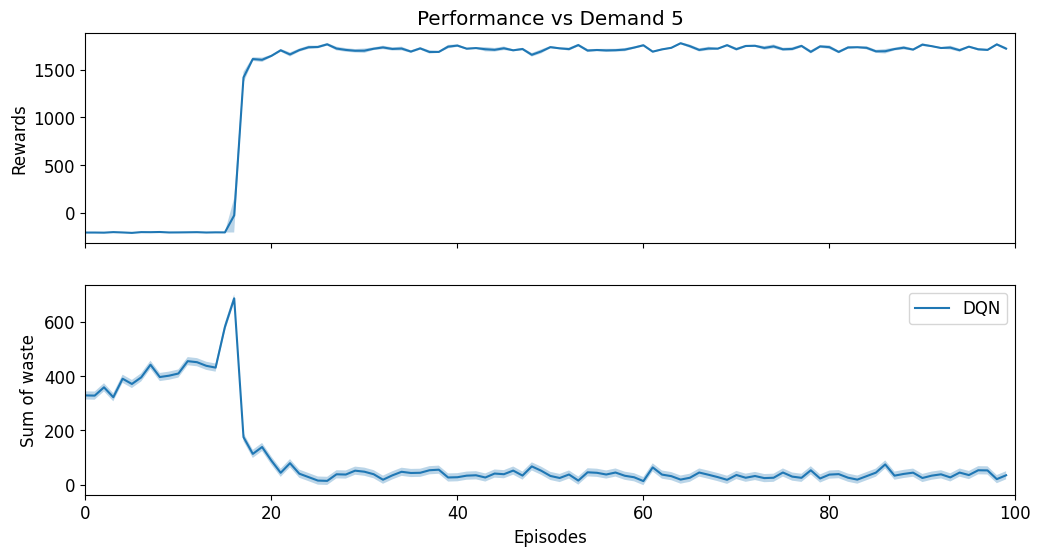

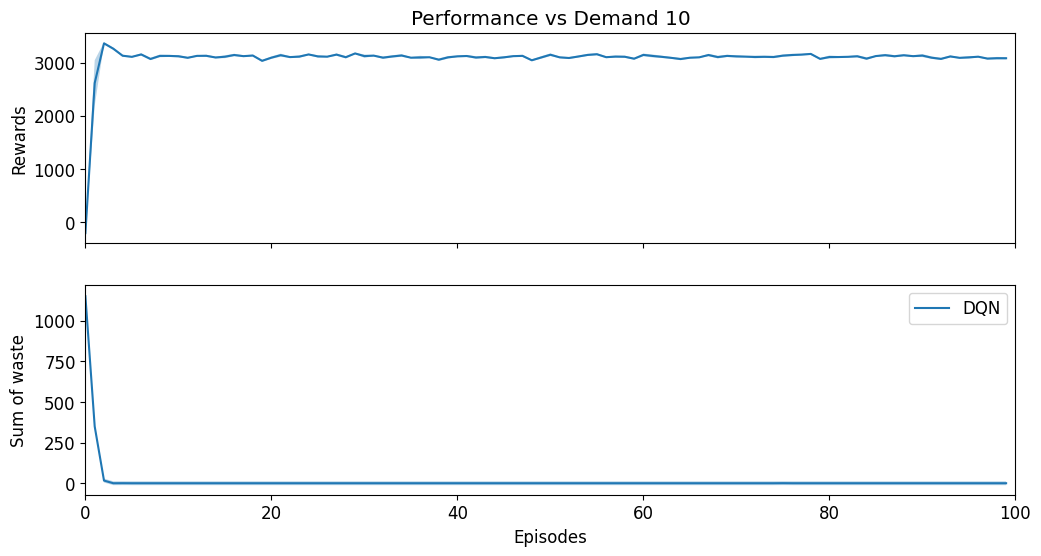

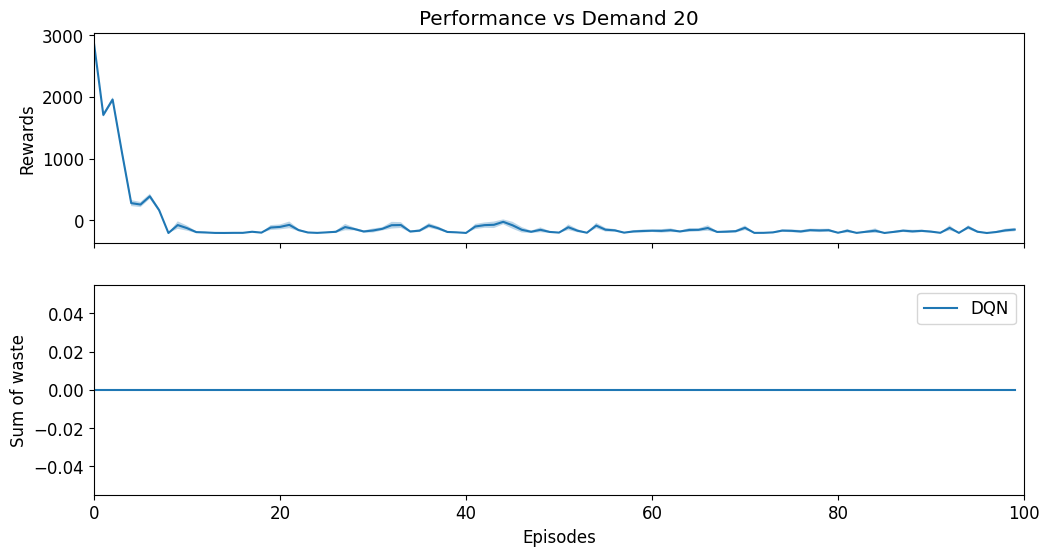

In [222]:
for i,wc in enumerate(demands):
    plot_results_rw(d_rewards[i], d_wastes[i], algos, {'x_lim':(0, 100), 'title': f'Performance vs Demand {wc}'})